In [1]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
num_sensors = 3
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
print(n, m)

1400 44219


We now select indices to divide the data into training, validation, and test sets.

In [2]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [3]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [4]:
transformed_X[1000][20000:21000]

array([ 0.344     ,  0.41298701,  0.48563969,  0.56216216,  0.56200528,
        0.31060606,  0.41755319,  0.31287129,  0.35375494,  0.35393258,
        0.35154827,  0.37316176,  0.46226415,  0.48780488,  0.4904943 ,
        0.48679245,  0.49360146,  0.5       ,  0.56930693,  0.54188482,
        0.53631285,  0.53650794,  0.58181818,  0.5942029 ,  0.57703081,
        0.57865169,  0.57344633,  0.55524079,  0.53631285,  0.53439153,
        0.54736842,  0.592     ,  0.62021858,  0.59090909,  0.57104558,
        0.5613079 ,  0.55367232,  0.5359116 ,  0.53611111,  0.52394366,
        0.50867052,  0.49529781,  0.5       ,  0.51020408,  0.52877698,
        0.57976654,  0.54330709,  0.50793651,  0.46303502,  0.4015444 ,
        0.39259259,  0.38827839,  0.38376384,  0.4028777 ,  0.38129496,
        0.35897436,  0.33454545,  0.37024221,  0.37710438,  0.37748344,
        0.3627451 ,  0.39423077,  0.37974684,  0.36163522,  0.33968254,
        0.25079365,  0.22292994,  0.21135647,  0.2218845 ,  0.29

We train the model using the training and validation datasets.

In [5]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4742)
Training epoch 2
Error tensor(0.4800)
Training epoch 3
Error tensor(0.4733)
Training epoch 4
Error tensor(0.4720)
Training epoch 5
Error tensor(0.4701)
Training epoch 6
Error tensor(0.4695)
Training epoch 7
Error tensor(0.4671)
Training epoch 8
Error tensor(0.4594)
Training epoch 9
Error tensor(0.3763)
Training epoch 10
Error tensor(0.3047)
Training epoch 11
Error tensor(0.3001)
Training epoch 12
Error tensor(0.2906)
Training epoch 13
Error tensor(0.2796)
Training epoch 14
Error tensor(0.2618)
Training epoch 15
Error tensor(0.2533)
Training epoch 16
Error tensor(0.2412)
Training epoch 17
Error tensor(0.2354)
Training epoch 18
Error tensor(0.2330)
Training epoch 19
Error tensor(0.2271)
Training epoch 20
Error tensor(0.2250)
Training epoch 21
Error tensor(0.2235)
Training epoch 22
Error tensor(0.2179)
Training epoch 23
Error tensor(0.2134)
Training epoch 24
Error tensor(0.2129)
Training epoch 25
Error tensor(0.2075)
Training epoch 26
Error tensor(0.2

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [6]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.033938035


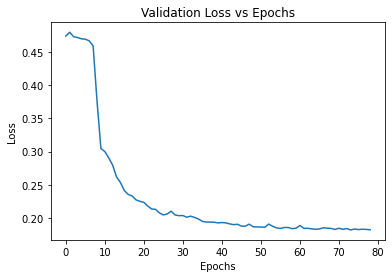

In [7]:
plt.plot(validation_errors)
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

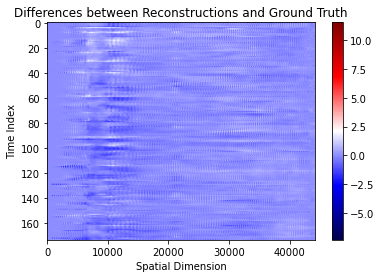

In [8]:
recons_differences = test_recons - test_ground_truth
plt.imshow(recons_differences, aspect='auto', cmap='seismic')
plt.title("Differences between Reconstructions and Ground Truth")
plt.xlabel("Spatial Dimension")
plt.ylabel("Time Index")
plt.colorbar()
plt.show()


In [9]:
lags_list = [1, 10, 26, 52, 78, 104]
mse_list = {}
errors = {}
for lags in lags_list:
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
    # (use the same code as before, updating the 'lags' variable)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

    # Get the test reconstructions
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

    # Calculate the mean squared error
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    mse_list[lags] = mse
    errors[lags] = validation_errors



Training epoch 1
Error tensor(0.5544)
Training epoch 2
Error tensor(0.4843)
Training epoch 3
Error tensor(0.4810)
Training epoch 4
Error tensor(0.4781)
Training epoch 5
Error tensor(0.4772)
Training epoch 6
Error tensor(0.4771)
Training epoch 7
Error tensor(0.4770)
Training epoch 8
Error tensor(0.4765)
Training epoch 9
Error tensor(0.4755)
Training epoch 10
Error tensor(0.4732)
Training epoch 11
Error tensor(0.4672)
Training epoch 12
Error tensor(0.3976)
Training epoch 13
Error tensor(0.3077)
Training epoch 14
Error tensor(0.3011)
Training epoch 15
Error tensor(0.2945)
Training epoch 16
Error tensor(0.2955)
Training epoch 17
Error tensor(0.2916)
Training epoch 18
Error tensor(0.2915)
Training epoch 19
Error tensor(0.2925)
Training epoch 20
Error tensor(0.2903)
Training epoch 21
Error tensor(0.2944)
Training epoch 22
Error tensor(0.2904)
Training epoch 23
Error tensor(0.2903)
Training epoch 24
Error tensor(0.2898)
Training epoch 25
Error tensor(0.2929)
Training epoch 26
Error tensor(0.2

In [10]:
mse_list2 = {1: 0.05255594,
 10: 0.04223417,
 26: 0.039454788,
 52: 0.037450165,
 78: 0.035178147,
 104: 0.03719792}
errors2 = {1: torch.tensor([0.5504, 0.4746, 0.4746, 0.4694, 0.4696, 0.4687, 0.4673, 0.4659, 0.4522,
         0.3315, 0.2956, 0.2891, 0.2872, 0.2841, 0.2886, 0.2819, 0.2795, 0.2785,
         0.2766, 0.2765, 0.2754, 0.2754, 0.2774, 0.2754, 0.2767, 0.2736, 0.2729,
         0.2743, 0.2757, 0.2726, 0.2735, 0.2739, 0.2728, 0.2731, 0.2717, 0.2742,
         0.2724, 0.2731, 0.2718, 0.2722]),
 10: torch.tensor([0.4749, 0.4773, 0.4711, 0.4709, 0.4667, 0.4588, 0.3783, 0.3266, 0.3014,
         0.2881, 0.2839, 0.2864, 0.2866, 0.2781, 0.2750, 0.2722, 0.2795, 0.2707,
         0.2670, 0.2718, 0.2622, 0.2555, 0.2508, 0.2482, 0.2480, 0.2460, 0.2440,
         0.2429, 0.2441, 0.2415, 0.2411, 0.2424, 0.2419, 0.2402, 0.2403, 0.2445,
         0.2397, 0.2419, 0.2406, 0.2410, 0.2371, 0.2372, 0.2382, 0.2385, 0.2363,
         0.2374, 0.2361, 0.2379, 0.2373, 0.2384, 0.2371, 0.2344, 0.2361, 0.2352,
         0.2363, 0.2425, 0.2350]),
 26: torch.tensor([0.4835, 0.4853, 0.4766, 0.4736, 0.4704, 0.4617, 0.3533, 0.2926, 0.2886,
         0.2842, 0.2799, 0.2745, 0.2697, 0.2621, 0.2531, 0.2455, 0.2390, 0.2414,
         0.2374, 0.2359, 0.2339, 0.2323, 0.2389, 0.2297, 0.2312, 0.2315, 0.2287,
         0.2284, 0.2294, 0.2284, 0.2290, 0.2319, 0.2277, 0.2290, 0.2296, 0.2275,
         0.2274, 0.2279, 0.2300, 0.2272, 0.2271, 0.2265, 0.2266, 0.2263, 0.2294,
         0.2289, 0.2255, 0.2255, 0.2282, 0.2263, 0.2262, 0.2267, 0.2257]),
 52: torch.tensor([0.4799, 0.4809, 0.4734, 0.4702, 0.4660, 0.4413, 0.3035, 0.2874, 0.2824,
         0.2740, 0.2666, 0.2658, 0.2527, 0.2483, 0.2346, 0.2312, 0.2299, 0.2257,
         0.2305, 0.2261, 0.2226, 0.2218, 0.2195, 0.2194, 0.2206, 0.2191, 0.2199,
         0.2209, 0.2201, 0.2183, 0.2189, 0.2202, 0.2195, 0.2198, 0.2183, 0.2173,
         0.2183, 0.2177, 0.2181, 0.2180, 0.2181]),
 78: torch.tensor([0.47071972, 0.47642136, 0.46960297, 0.4676721 , 0.46511832,
        0.46002388, 0.38179004, 0.29590926, 0.28467026, 0.28034252,
        0.27530244, 0.2690953 , 0.2605339 , 0.2543418 , 0.2490787 ,
        0.2424967 , 0.23678496, 0.2345042 , 0.22993028, 0.22816531,
        0.22560464, 0.23105097, 0.22516106, 0.22524479, 0.22349043,
        0.22270167, 0.2224364 , 0.22229442, 0.22360617, 0.22496605,
        0.22465603, 0.22137405, 0.22252594, 0.22321735, 0.22076742,
        0.22052075, 0.22120117, 0.22150904, 0.22052589, 0.22040254,
        0.2213266 , 0.22038716, 0.22049902, 0.21970269, 0.22122294,
        0.22050576, 0.22182958, 0.21934119, 0.21914719, 0.2221096 ,
        0.22039461, 0.22025473, 0.22102411, 0.21861583, 0.21828957,
        0.21916315, 0.21970952, 0.21870944, 0.2182774 , 0.21786804,
        0.21846975, 0.21753775, 0.21735184, 0.21730873, 0.21661705,
        0.21734911, 0.21563214, 0.21751009, 0.21583822, 0.21592195,
        0.21545716, 0.21702936, 0.21446472, 0.21631022, 0.21549149,
        0.21491379, 0.21373616, 0.21406405, 0.21448341, 0.21357255,
        0.21396272, 0.21346389, 0.21600057, 0.21225336, 0.21334535,
        0.21247381, 0.2115287 , 0.2109734 , 0.21219529, 0.21085827,
        0.2120179 , 0.21375929, 0.21669859, 0.21170716, 0.20960867,
        0.20856467, 0.21044005, 0.20919257, 0.21211605, 0.20820123],),
 104: torch.tensor([0.4730, 0.4787, 0.4685, 0.4657, 0.4627, 0.4430, 0.3086, 0.2917, 0.2900,
         0.2832, 0.2762, 0.2681, 0.2602, 0.2491, 0.2394, 0.2355, 0.2326, 0.2322,
         0.2294, 0.2283, 0.2279, 0.2269, 0.2249, 0.2244, 0.2296, 0.2245, 0.2248,
         0.2239, 0.2224, 0.2233, 0.2235, 0.2220, 0.2235, 0.2223, 0.2219, 0.2226,
         0.2227, 0.2233, 0.2217, 0.2224, 0.2248, 0.2219, 0.2217, 0.2227])}

In [42]:
mse_list3 = {1: 0.053542882,
 10: 0.03448026,
 26: 0.026789231,
 52: 0.025145791,
 78: 0.025685519,
 104: 0.026096517}
errors3 = {1: np.array([0.5544157 , 0.4843175 , 0.48098856, 0.47812483, 0.47724763,
        0.47709623, 0.47695073, 0.47652403, 0.4754683 , 0.47318515,
        0.46718168, 0.3976483 , 0.30767626, 0.30107424, 0.29446805,
        0.29551744, 0.29164365, 0.2914902 , 0.29248255, 0.290255  ,
        0.2944097 , 0.29040912, 0.29026708, 0.28979367, 0.29288745,
        0.2927584 , 0.29346722, 0.28969985, 0.28894904, 0.29406306,
        0.29058757, 0.289915  , 0.2892587 , 0.28791988, 0.29056174,
        0.2900417 , 0.2889971 , 0.2903941 , 0.28980052, 0.28884843,
        0.28827542, 0.29161623, 0.29025456, 0.28942114, 0.28912643,
        0.2893697 , 0.28885952, 0.28731132, 0.287338  , 0.28801808,
        0.28944436, 0.28743154, 0.28637585, 0.2856989 , 0.28402194,
        0.28895798, 0.28460044, 0.27855018, 0.27789158, 0.27548778,
        0.27690926, 0.2718261 , 0.2728782 , 0.2679405 , 0.2661969 ,
        0.26862332, 0.26648784, 0.264811  , 0.26221117, 0.26266754,
        0.26318523, 0.26403314, 0.2629165 , 0.2639283 , 0.26271382,
        0.26321703, 0.26229033, 0.26274365, 0.26231286, 0.26205352,
        0.26453245, 0.26356485, 0.26328617, 0.26253942, 0.2615052 ,
        0.2656539 , 0.2620374 , 0.26157308, 0.26353619, 0.2615535 ,
        0.26267895, 0.26749256, 0.27017173, 0.26228562, 0.26283756,
        0.26582512, 0.2630668 , 0.26133907, 0.26009536, 0.26108012,
        0.25988635, 0.26237252, 0.25986892, 0.26160717, 0.26148766,
        0.26300797, 0.25950828, 0.25919247, 0.26377243, 0.2640551 ,
        0.2601505 , 0.26155308, 0.25918907, 0.26238716, 0.26308164,
        0.2585412 , 0.25916836, 0.2614687 , 0.26048774, 0.25828648,
        0.26124692, 0.25761223, 0.25738293, 0.25845656, 0.26395303,
        0.2578518 , 0.2588538 , 0.26036245, 0.25728434, 0.2602429 ,
        0.2567816 , 0.25725466, 0.25624377, 0.2591809 , 0.2603683 ,
        0.25729474, 0.2559554 , 0.26054084, 0.25725138, 0.2562242 ,
        0.260007  , 0.2569665 , 0.25676888, 0.25725397, 0.25772217,
        0.25689164, 0.25721228, 0.25606006, 0.26089412, 0.2559163 ,
        0.25615335, 0.25662944, 0.25618768, 0.2557786 , 0.25873592,
        0.25822365, 0.25592977, 0.25674868, 0.2554474 , 0.26021236,
        0.25482976, 0.2575509 , 0.25938013, 0.25694755, 0.2569478 ,
        0.25707725, 0.26009765, 0.25427788, 0.2560312 , 0.2582469 ,
        0.25506076, 0.2552024 , 0.25855637, 0.25426096, 0.25896737,
        0.25438526, 0.2559415 , 0.25770125, 0.25654447, 0.255612  ,
        0.2622923 , 0.2565099 , 0.2554989 , 0.2572455 , 0.260968  ,
        0.25724006, 0.2532869 , 0.25533116, 0.25840175, 0.25638846,
        0.2535198 , 0.25461647, 0.25567463, 0.25629124, 0.2545903 ,
        0.25641668, 0.26007065, 0.25615445, 0.25659117, 0.25568324,
        0.2559569 , 0.25646788, 0.25654605, 0.25712442, 0.25614715,
        0.26004753, 0.25307658, 0.2558962 , 0.25596315, 0.25612527,
        0.2544035 , 0.2542317 , 0.25393355, 0.26088807, 0.2554021 ,
        0.25536647, 0.25668886, 0.25646538, 0.25676024, 0.2555836 ,
        0.2551225 , 0.25555155, 0.2565555 , 0.25894514, 0.26175165,
        0.25738236, 0.25310355, 0.2557725 , 0.2589017 , 0.25615138,
        0.25780898, 0.25596493, 0.25417602, 0.2556255 , 0.25513533,
        0.2542717 , 0.2540115 , 0.26266167, 0.25677568, 0.25564748,
        0.25649977, 0.25652218, 0.25497505, 0.2567565 , 0.25552663,
        0.25674406, 0.2550135 , 0.25719953, 0.2600979 , 0.2566115 ]),
 10: np.array([0.4807086 , 0.48504576, 0.4742212 , 0.47271675, 0.47225344,
        0.47086698, 0.46693563, 0.43526593, 0.3655758 , 0.33013672,
        0.30828467, 0.2928286 , 0.28939262, 0.2894927 , 0.28689826,
        0.2860697 , 0.28690118, 0.28299108, 0.27896857, 0.27478826,
        0.26614505, 0.26149413, 0.2611056 , 0.2558193 , 0.25903255,
        0.2537622 , 0.24846496, 0.24656059, 0.23828411, 0.23582931,
        0.23964599, 0.24557383, 0.23421514, 0.23406741, 0.23011017,
        0.22888774, 0.22619517, 0.22545113, 0.22359543, 0.2212404 ,
        0.22249933, 0.22288111, 0.22575746, 0.22169618, 0.2204494 ,
        0.21907665, 0.22220808, 0.22177003, 0.21726388, 0.21687116,
        0.21750112, 0.21836656, 0.21585466, 0.21677263, 0.21498387,
        0.21576005, 0.21561947, 0.21443625, 0.21600564, 0.21610732,
        0.21282297, 0.2117538 , 0.2170748 , 0.21140583, 0.21622016,
        0.21335699, 0.21134646, 0.21223561, 0.21307886, 0.21140788,
        0.21044573, 0.21029216, 0.21548453, 0.21275163, 0.21051526,
        0.21084778, 0.20925471, 0.20943013, 0.2093036 , 0.2146969 ,
        0.20913817, 0.21050532, 0.21203794, 0.20774819, 0.20914668,
        0.21322487, 0.20900144, 0.21149307, 0.20984119, 0.21104729,
        0.20881571, 0.21024705, 0.20648219, 0.20845895, 0.2090082 ,
        0.20681599, 0.20632416, 0.20673735, 0.20952857, 0.20671935,
        0.20638916, 0.20683974, 0.21023703, 0.20694138, 0.20653772,
        0.20523627, 0.20333786, 0.20529887, 0.20307052, 0.20560639,
        0.20607954, 0.20333497, 0.20468898, 0.20296206, 0.20196211,
        0.20489895, 0.20264225, 0.20427845, 0.20397097, 0.2001267 ,
        0.19951425, 0.20154332, 0.20027454, 0.20011276, 0.20212549,
        0.19999617, 0.19998711, 0.19815624, 0.20007887, 0.20101884,
        0.19838649, 0.1985063 , 0.19885193, 0.19780183, 0.20035522,
        0.19837897, 0.1993874 , 0.19891891, 0.19807681, 0.19924621,
        0.19877931, 0.1986131 , 0.19765963, 0.20064893, 0.19574274,
        0.1972981 , 0.1996065 , 0.19603713, 0.1962187 , 0.19632071,
        0.19773677, 0.19554782, 0.19641529, 0.19633679, 0.19633451,
        0.19632384, 0.19635372, 0.19564989, 0.19594452, 0.19491896,
        0.19458134, 0.1954797 , 0.19768755, 0.19676456, 0.19654639,
        0.19418907, 0.19502443, 0.19289444, 0.19458304, 0.19231516,
        0.19491923, 0.19598114, 0.19502193, 0.19346546, 0.1935843 ,
        0.19163789, 0.19302979, 0.19422221, 0.19571303, 0.19200812,
        0.19181846, 0.19228783, 0.1921312 , 0.19185114, 0.19540347,
        0.19141757, 0.1922738 , 0.19088998, 0.192528  , 0.19306104,
        0.19302064, 0.19004066, 0.18984267, 0.18971176, 0.19053659,
        0.19161972, 0.190606  , 0.19011348, 0.18915956, 0.18961605,
        0.19051704, 0.18797134, 0.19020669, 0.18829378, 0.18850027,
        0.18914983, 0.18953924, 0.18945761, 0.18958268, 0.18842974,
        0.18981694, 0.18717647, 0.18724379, 0.18930069, 0.18680127,
        0.18971804, 0.18675277, 0.18666837, 0.1871166 , 0.18763393,
        0.18717897, 0.18782747, 0.18545334, 0.18445809, 0.1862651 ,
        0.1871317 , 0.1851766 , 0.1874242 , 0.18660057, 0.18545671,
        0.18331216, 0.18361203, 0.18408348, 0.18418439, 0.18466307,
        0.1836961 , 0.1827825 , 0.18550757, 0.18461563, 0.18744422,
        0.1864177 , 0.18177469, 0.18331075, 0.18186142, 0.18073823,
        0.18177968, 0.18137324, 0.18183745, 0.18139383, 0.18229067]),
 26: np.array([0.4760933 , 0.47974068, 0.47264963, 0.47256488, 0.47124645,
        0.46888876, 0.4658498 , 0.45300406, 0.32719454, 0.29404208,
        0.28512484, 0.28154206, 0.27620393, 0.26916635, 0.26113203,
        0.24631591, 0.24019125, 0.23912321, 0.24538067, 0.23308179,
        0.22762486, 0.22129382, 0.22094469, 0.21508858, 0.2150345 ,
        0.21424823, 0.21314086, 0.21092239, 0.21369988, 0.20929244,
        0.2086389 , 0.20686455, 0.20677689, 0.21080913, 0.21157734,
        0.20678829, 0.20329618, 0.20080137, 0.20030245, 0.2003913 ,
        0.1991724 , 0.19753215, 0.19763808, 0.1971954 , 0.19652696,
        0.19651246, 0.19728287, 0.19630633, 0.19607283, 0.19562924,
        0.19355758, 0.19607802, 0.19658923, 0.19282107, 0.19024876,
        0.19249332, 0.19301775, 0.19107862, 0.18936884, 0.193296  ,
        0.18875812, 0.1910042 , 0.19047546, 0.18779056, 0.18765622,
        0.1895484 , 0.19104707, 0.18860959, 0.18716994, 0.1869853 ,
        0.18654811, 0.18661053, 0.18652995, 0.18744823, 0.18682969,
        0.18552335, 0.18560877, 0.18806997, 0.18483005, 0.18841279,
        0.18643099, 0.1866157 , 0.18458639, 0.1826039 , 0.18490072,
        0.18476517, 0.18427269, 0.18253747, 0.1821248 , 0.18486208,
        0.18349272, 0.18252827, 0.18099004, 0.18265454, 0.18313217,
        0.18190093, 0.18211298, 0.18312171, 0.18281628, 0.18357246,
        0.18204325, 0.17931361, 0.18119518, 0.18057814, 0.18348262,
        0.18690062, 0.18307255, 0.17892233, 0.18004175, 0.1803575 ,
        0.17923576, 0.1811709 , 0.17748012, 0.17860653, 0.17860402,
        0.17789795, 0.17666365, 0.18138291, 0.17766708, 0.17601287,
        0.17586364, 0.17729467, 0.17947915, 0.17767143, 0.17867261,
        0.17527153, 0.17677324, 0.17363754, 0.17461824, 0.17489606,
        0.17577341, 0.1741504 , 0.17301694, 0.1729985 , 0.17233005,
        0.1719797 , 0.17202191, 0.17202355, 0.17244996, 0.17182215,
        0.17162031, 0.17089677, 0.1714215 , 0.17037413, 0.17226268,
        0.1716127 , 0.17009461, 0.17194201, 0.17304532, 0.16973881,
        0.16775675, 0.17169425, 0.16715893, 0.1690998 , 0.1671792 ,
        0.16806522, 0.16823032, 0.16929345, 0.16620882, 0.16699438,
        0.16703218, 0.16781765, 0.16690555, 0.1659565 , 0.16484381,
        0.1646139 , 0.16377735, 0.16469471, 0.16385621, 0.16293429,
        0.16365613, 0.16289908, 0.16334777, 0.16263764, 0.16198345,
        0.16184646, 0.16429316, 0.16231783, 0.16327192, 0.16051076,
        0.15996698, 0.16097377, 0.16200137, 0.16138263, 0.15934506,
        0.1580361 , 0.16025253, 0.15784928, 0.15936582, 0.15823291,
        0.15836877, 0.15929613, 0.15674561, 0.15728319, 0.15658669,
        0.15740481, 0.15534516, 0.1566516 , 0.15706538, 0.15609668,
        0.15624435, 0.15709509, 0.15538384, 0.1555219 , 0.15461865,
        0.15342738, 0.15417065, 0.15347387, 0.15240122, 0.1527878 ,
        0.15334006, 0.15284824, 0.15355347, 0.1535048 , 0.15105455,
        0.15191427, 0.15000251, 0.15114865, 0.15239994, 0.15196727,
        0.14979175, 0.15224135, 0.1517605 , 0.14959577, 0.15369685,
        0.15125395, 0.15024576, 0.14983587, 0.1502918 , 0.15074801,
        0.14855064, 0.14888652, 0.14752553, 0.1473741 , 0.14757538,
        0.14642663, 0.14615174, 0.14786056, 0.14677513, 0.1464412 ,
        0.1469432 , 0.14916953, 0.14654745, 0.14885984, 0.1483347 ,
        0.14544477, 0.1453168 , 0.14515005, 0.14736475, 0.14519475]),
 52: np.array([0.4752454 , 0.47773302, 0.46704966, 0.46786147, 0.46624702,
        0.46454722, 0.4602183 , 0.43778992, 0.3140483 , 0.29880637,
        0.309003  , 0.2897479 , 0.2794219 , 0.27162915, 0.2627749 ,
        0.2525832 , 0.23830456, 0.23313387, 0.23004712, 0.22910523,
        0.22922316, 0.22591096, 0.22501005, 0.22241482, 0.21668343,
        0.209448  , 0.21730189, 0.2053718 , 0.21065187, 0.20604019,
        0.20439444, 0.2015129 , 0.20021777, 0.19930428, 0.19575171,
        0.19887422, 0.19280216, 0.19288632, 0.19375691, 0.1920231 ,
        0.19051947, 0.18973881, 0.19129167, 0.18814169, 0.18777138,
        0.18779281, 0.18696927, 0.18694463, 0.1886288 , 0.18750256,
        0.18832633, 0.18746664, 0.18715313, 0.18653065, 0.18783352,
        0.18817529, 0.18655024, 0.18411058, 0.18678813, 0.18387787,
        0.18355139, 0.18699917, 0.18586339, 0.18395185, 0.18348655,
        0.18510641, 0.18282071, 0.18718989, 0.18362753, 0.18208516,
        0.18451567, 0.18289977, 0.18175668, 0.1825485 , 0.18284507,
        0.18327262, 0.18322936, 0.18223007, 0.18048446, 0.1817852 ,
        0.18271546, 0.18525308, 0.18203299, 0.18145218, 0.18094292,
        0.18090525, 0.18049194, 0.1801535 , 0.1801701 , 0.18055625,
        0.18044426, 0.18108167, 0.18127361, 0.1793722 , 0.1788469 ,
        0.17857073, 0.17974946, 0.17853692, 0.17882834, 0.17849277,
        0.17781813, 0.17778924, 0.18122587, 0.17870784, 0.17719312,
        0.17815478, 0.17706586, 0.17780147, 0.17701653, 0.17633349,
        0.17695284, 0.17673144, 0.17800425, 0.1807862 , 0.17618786,
        0.17546035, 0.176289  , 0.17651017, 0.17743213, 0.17618415,
        0.17477027, 0.17630522, 0.17474389, 0.17596102, 0.17474443,
        0.17382795, 0.17603968, 0.17489526, 0.17367609, 0.17277454,
        0.1737787 , 0.1731379 , 0.17273518, 0.17277338, 0.17241865,
        0.17184663, 0.17304619, 0.17242536, 0.17272207, 0.17240846,
        0.1740263 , 0.17152047, 0.17337127, 0.17068756, 0.17103167,
        0.17099467, 0.17089225, 0.17024727, 0.16982104, 0.1700165 ,
        0.16828361, 0.16795821, 0.16907161, 0.16761222, 0.16839851,
        0.1688161 , 0.17218429, 0.16695964, 0.16583003, 0.16537443,
        0.16532387, 0.16472596, 0.16502987, 0.164623  , 0.16720778,
        0.16312645, 0.16390233, 0.16368961, 0.16343191, 0.16188125,
        0.16265805, 0.16063622, 0.16215397, 0.16013417, 0.15970056,
        0.15966931, 0.15978952, 0.15951048, 0.15885293, 0.15908282,
        0.15899035, 0.15721314, 0.15734386, 0.15933551, 0.15769592,
        0.15586461, 0.15640147, 0.15745702, 0.15494421, 0.15535723,
        0.15499395, 0.15559892, 0.15643299, 0.15610774, 0.1532893 ,
        0.1525485 , 0.15179795, 0.15182734, 0.15240233, 0.15094413,
        0.15235746, 0.15045553, 0.14977464, 0.15003417, 0.14900517,
        0.14955766, 0.14919935, 0.14957309, 0.14755958, 0.14987876,
        0.14769067, 0.1474741 , 0.14706044, 0.14618178, 0.14703503,
        0.14556234, 0.14498721, 0.14487855, 0.1447568 , 0.14488907,
        0.14510633, 0.14468466, 0.1433584 , 0.14281899, 0.14150488,
        0.14362758, 0.14291441, 0.14233705, 0.14122121, 0.14253901,
        0.14263418, 0.14143668, 0.14007643, 0.13891679, 0.13988009,
        0.14111948, 0.14066073, 0.14172906, 0.13893086, 0.13821656,
        0.13793367, 0.13893767, 0.13714921, 0.13671322, 0.13761096,
        0.13778736, 0.13847409, 0.13646878, 0.13838744, 0.13685471]),
 78: np.array([0.47362232, 0.47685903, 0.47250828, 0.46990758, 0.47011653,
        0.47010878, 0.46973866, 0.46578732, 0.4537148 , 0.31627968,
        0.30679804, 0.2986095 , 0.29284653, 0.28155783, 0.27669084,
        0.27170274, 0.27029544, 0.2567917 , 0.24448933, 0.23622078,
        0.2325596 , 0.2271588 , 0.22455013, 0.2231557 , 0.22118077,
        0.21958493, 0.21720389, 0.20845847, 0.20136186, 0.19880077,
        0.19551758, 0.19543964, 0.19688375, 0.19367957, 0.19350548,
        0.18993714, 0.19105431, 0.19098909, 0.19027863, 0.18879806,
        0.18839078, 0.18817766, 0.18917397, 0.18914631, 0.18667041,
        0.18639669, 0.18488742, 0.1848492 , 0.1854696 , 0.18355295,
        0.18511958, 0.18365186, 0.18233794, 0.18345995, 0.1824808 ,
        0.18172802, 0.18277988, 0.18079767, 0.18243703, 0.18377967,
        0.18103164, 0.18366578, 0.18130387, 0.18168424, 0.18196513,
        0.18138848, 0.17973901, 0.18058075, 0.17908998, 0.1788993 ,
        0.17988922, 0.1793491 , 0.17979297, 0.18361121, 0.17830372,
        0.17837502, 0.1780875 , 0.1784258 , 0.17700641, 0.18149576,
        0.17806558, 0.17926742, 0.17781758, 0.1777769 , 0.17637698,
        0.17701611, 0.1768046 , 0.17685816, 0.1765512 , 0.17515914,
        0.17675875, 0.17766966, 0.1756736 , 0.17628193, 0.17835058,
        0.17449121, 0.17683797, 0.17968574, 0.17480268, 0.17434822,
        0.17497417, 0.17895906, 0.17514364, 0.17530097, 0.1734883 ,
        0.17643341, 0.17377093, 0.17546508, 0.17406437, 0.17417285,
        0.17304711, 0.17373799, 0.17252743, 0.1716814 , 0.17258875,
        0.17217146, 0.1716482 , 0.1725976 , 0.17079619, 0.17067096,
        0.17278118, 0.17113489, 0.17155163, 0.17194787, 0.17177457,
        0.1709515 , 0.17151746, 0.16998203, 0.17006537, 0.1685381 ,
        0.16940014, 0.16904527, 0.16782993, 0.16855186, 0.16998638,
        0.16921152, 0.16771199, 0.16732503, 0.16655748, 0.16621116,
        0.16733676, 0.1660193 , 0.16580054, 0.16514717, 0.16502954,
        0.16501331, 0.16436106, 0.16576108, 0.16508283, 0.16327083,
        0.16386038, 0.16366349, 0.1624824 , 0.16258079, 0.16300263,
        0.16147178, 0.16229543, 0.16188423, 0.16209714, 0.16103993,
        0.1615864 , 0.16082862, 0.16013192, 0.16059373, 0.15992008,
        0.16059622, 0.16162778, 0.16290487, 0.1625791 , 0.16049044,
        0.16012381, 0.160854  , 0.15849945, 0.15788473, 0.15711649,
        0.15827687, 0.15736872, 0.15924752, 0.15700367, 0.15566766,
        0.155097  , 0.15576482, 0.1556184 , 0.15544237, 0.15593879,
        0.15400898, 0.1540388 , 0.15480629, 0.15413967, 0.15433303,
        0.1531436 , 0.15372469, 0.15663566, 0.1534286 , 0.15200093,
        0.15413733, 0.15384899, 0.15154958, 0.15200847, 0.15016505,
        0.15307836, 0.15125737, 0.15026787, 0.14945377, 0.15014812,
        0.14858355, 0.15144157, 0.14900939, 0.14954044, 0.1514608 ,
        0.14903122, 0.14749865, 0.14758345, 0.1470962 , 0.14718339,
        0.14878388, 0.14645033, 0.1476513 , 0.14754283, 0.14547597,
        0.145928  , 0.14335129, 0.14592032, 0.14537615, 0.14289287,
        0.14451112, 0.1445968 , 0.14326383, 0.14192902, 0.14380099,
        0.14210366, 0.14150381, 0.14204197, 0.14411114, 0.14122942,
        0.14120965, 0.14057748, 0.14127922, 0.13997558, 0.14109722,
        0.14104089, 0.14085722, 0.1402303 , 0.13842374, 0.14008772,
        0.14188927, 0.13792045, 0.13693434, 0.1369052 , 0.13673888]),
 104: np.array([0.47944546, 0.47724524, 0.46884045, 0.46761593, 0.4670436 ,
        0.46645904, 0.46355593, 0.45086935, 0.32122102, 0.3024684 ,
        0.29540008, 0.28622088, 0.28288123, 0.27598622, 0.26981768,
        0.26662183, 0.24975362, 0.24745691, 0.23747538, 0.23438844,
        0.23439884, 0.2270332 , 0.22541454, 0.22606933, 0.22315624,
        0.22091867, 0.21836494, 0.21241607, 0.20857339, 0.20665374,
        0.20363197, 0.20085785, 0.19972493, 0.19760726, 0.19581337,
        0.19575293, 0.19526054, 0.19634718, 0.1976563 , 0.19457117,
        0.19501185, 0.19220373, 0.19371995, 0.19039957, 0.1898412 ,
        0.1895547 , 0.18832378, 0.19208866, 0.19285531, 0.18991458,
        0.18752405, 0.18726176, 0.1881711 , 0.1872923 , 0.18765144,
        0.1863547 , 0.1886196 , 0.18744382, 0.18698376, 0.18735677,
        0.18703961, 0.19103691, 0.18778291, 0.18456618, 0.18577875,
        0.18483402, 0.18521342, 0.18880832, 0.18622737, 0.18453251,
        0.18375209, 0.18427598, 0.18579261, 0.18689635, 0.1857226 ,
        0.18623625, 0.18605882, 0.18374668, 0.18257615, 0.1827383 ,
        0.18435663, 0.18284789, 0.18392318, 0.18493843, 0.18306527,
        0.18478481, 0.18177573, 0.18414079, 0.18293412, 0.18365666,
        0.18267526, 0.18098693, 0.18074244, 0.18020622, 0.18173198,
        0.1811623 , 0.18182492, 0.17965792, 0.18117298, 0.17897332,
        0.18055984, 0.1790002 , 0.1797117 , 0.18129823, 0.17923206,
        0.18017764, 0.18011706, 0.1792224 , 0.17785656, 0.17844145,
        0.18028349, 0.17729135, 0.17679992, 0.17808384, 0.17669585,
        0.17775214, 0.17680149, 0.17729542, 0.17745033, 0.17613578,
        0.17717959, 0.17613573, 0.17572495, 0.17552169, 0.17566402,
        0.17645243, 0.17549175, 0.17483701, 0.17605895, 0.17500652,
        0.17443623, 0.17439893, 0.1753271 , 0.17623354, 0.17424501,
        0.1747337 , 0.17413399, 0.174816  , 0.17379525, 0.17246644,
        0.1721742 , 0.17133299, 0.17333654, 0.1725723 , 0.1717238 ,
        0.17278205, 0.17212564, 0.1710806 , 0.1711858 , 0.17015566,
        0.1689794 , 0.16990109, 0.16934147, 0.17059064, 0.16983467,
        0.17082383, 0.16868198, 0.1694177 , 0.1680372 , 0.16810831,
        0.16899696, 0.16775386, 0.16727257, 0.16714703, 0.16799812,
        0.16728526, 0.16621087, 0.16661374, 0.16666041, 0.16589361,
        0.16520558, 0.16581428, 0.1651414 , 0.16452995, 0.1633922 ,
        0.16446412, 0.16527596, 0.16528948, 0.16390601, 0.16258326,
        0.16367143, 0.16127136, 0.16181388, 0.16198906, 0.16196904,
        0.16153817, 0.16291745, 0.16057912, 0.16030908, 0.1609358 ,
        0.16229816, 0.16148372, 0.15992036, 0.15940008, 0.16009726,
        0.15865545, 0.15816534, 0.15934426, 0.15806419, 0.15752271,
        0.156959  , 0.1581694 , 0.15676385, 0.1588447 , 0.15592098,
        0.15514445, 0.154559  , 0.15608086, 0.15515186, 0.15450692,
        0.15500164, 0.15399936, 0.15413651, 0.15690638, 0.15246053,
        0.15438685, 0.15359755, 0.15383618, 0.15308869, 0.15302153,
        0.15247677, 0.15253897, 0.15224476, 0.15057899, 0.15034813,
        0.14948344, 0.15101783, 0.15097047, 0.1498055 , 0.1481986 ,
        0.14902817, 0.14800082, 0.14875019, 0.14922403, 0.1476361 ,
        0.14705035, 0.14781718, 0.14661352, 0.147266  , 0.14551677,
        0.14866816, 0.14531983, 0.14619423, 0.14746545, 0.1449569 ,
        0.14545035, 0.14377028, 0.14376846, 0.14471668, 0.1434343 ])}

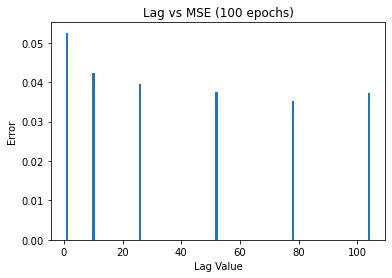

In [52]:
plt.bar(lags_list, list(mse_list2.values()))
plt.xlabel("Lag Value")
plt.ylabel("Error")
plt.title("Lag vs MSE (100 epochs)")
plt.show()

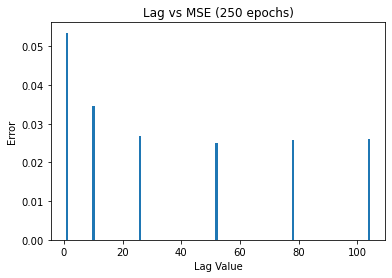

In [54]:
plt.bar(lags_list, list(mse_list3.values()))
plt.xlabel("Lag Value")
plt.ylabel("Error")
plt.title("Lag vs MSE (250 epochs)")
plt.show()

Text(0.5, 1.0, 'Training Error (100 epochs)')

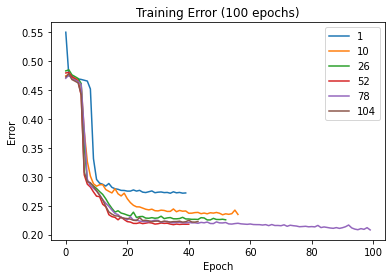

In [49]:
for i in lags_list:
    plt.plot(errors2[i], label=i)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error (100 epochs)")

Text(0.5, 1.0, 'Training Error (250 epochs)')

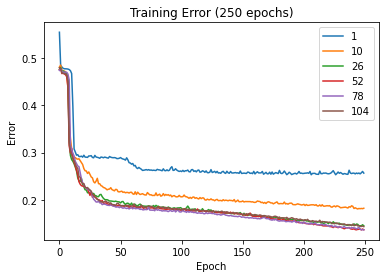

In [50]:
for i in lags_list:
    plt.plot(errors3[i], label=i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error (250 epochs)")

In [15]:
noise_levels = [0, .05, .1, .25, .5, 1]
mse_list_noise = {}
error_list_noise = {}
num_sensors = 3
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
transformed_X = sc.transform(load_X)

for noise_level in noise_levels:
    # Add Gaussian noise to the transformed data
    noisy_data = transformed_X + np.random.normal(0, noise_level, transformed_X.shape)
    ...

    # Modify the input generation and training/validation/test datasets for the noisy data
    # (use the same code as before, updating the 'all_data_in' definition)
    ...
    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = noisy_data[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(noisy_data[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(noisy_data[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(noisy_data[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

    # Get the test reconstructions
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

    # Calculate the mean squared error
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    mse_list_noise[noise_level] = mse
    error_list_noise[noise_level] = validation_errors

Training epoch 1
Error tensor(0.4700)
Training epoch 2
Error tensor(0.4771)
Training epoch 3
Error tensor(0.4683)
Training epoch 4
Error tensor(0.4666)
Training epoch 5
Error tensor(0.4644)
Training epoch 6
Error tensor(0.4556)
Training epoch 7
Error tensor(0.3736)
Training epoch 8
Error tensor(0.2790)
Training epoch 9
Error tensor(0.2768)
Training epoch 10
Error tensor(0.2789)
Training epoch 11
Error tensor(0.2699)
Training epoch 12
Error tensor(0.2650)
Training epoch 13
Error tensor(0.2614)
Training epoch 14
Error tensor(0.2576)
Training epoch 15
Error tensor(0.2532)
Training epoch 16
Error tensor(0.2487)
Training epoch 17
Error tensor(0.2382)
Training epoch 18
Error tensor(0.2310)
Training epoch 19
Error tensor(0.2261)
Training epoch 20
Error tensor(0.2248)
Training epoch 21
Error tensor(0.2249)
Training epoch 22
Error tensor(0.2238)
Training epoch 23
Error tensor(0.2217)
Training epoch 24
Error tensor(0.2192)
Training epoch 25
Error tensor(0.2121)
Training epoch 26
Error tensor(0.2

In [36]:
mse_list_noise3 = {0: 0.028785978,
 0.05: 0.03470098,
 0.1: 0.052449547,
 0.25: 0.116715156,
 0.5: 0.2311621,
 1: 0.43381342}
error_list_noise3 = {0: np.array([0.469999  , 0.47705388, 0.4683249 , 0.4666323 , 0.46441227,
        0.455585  , 0.3735636 , 0.27902454, 0.27679804, 0.27886164,
        0.26991326, 0.26497236, 0.2614046 , 0.25759923, 0.25320655,
        0.2486954 , 0.23816516, 0.23103414, 0.22612813, 0.22475648,
        0.22489697, 0.22376762, 0.221719  , 0.21917522, 0.2120581 ,
        0.20661052, 0.20251858, 0.20250982, 0.20056432, 0.20082343,
        0.19994536, 0.20149511, 0.19976354, 0.19876891, 0.19883828,
        0.2016026 , 0.20139898, 0.19966614, 0.20024155, 0.19978902,
        0.20016363, 0.20008072, 0.1984331 , 0.19769299, 0.19851501,
        0.19739786, 0.19630077, 0.19690944, 0.19677934, 0.19879045,
        0.19782707, 0.19788212, 0.19776286, 0.1971166 , 0.19696169,
        0.19574094, 0.19692843, 0.19548659, 0.19675623, 0.19731721,
        0.19592237, 0.19721293, 0.19618149, 0.19612671, 0.19585373,
        0.19488785, 0.19567513, 0.19689393, 0.19645657, 0.1974159 ,
        0.19476181, 0.19453512, 0.1957957 , 0.19544972, 0.1963611 ,
        0.19639462, 0.19385223, 0.19392431, 0.19377786, 0.19664185,
        0.19221821, 0.19375767, 0.1934103 , 0.19198924, 0.19225855,
        0.19489159, 0.19245447, 0.19382933, 0.1917752 , 0.19147493,
        0.19325463, 0.1913386 , 0.19282338, 0.1912046 , 0.19011487,
        0.19015002, 0.19092628, 0.19283268, 0.18991847, 0.19380474,
        0.1898649 , 0.1893324 , 0.1899162 , 0.19004487, 0.19105524,
        0.19329932, 0.19146551, 0.19030128, 0.19068241, 0.18886074,
        0.18856764, 0.18884479, 0.18788312, 0.19243158, 0.18793625,
        0.18751264, 0.18971556, 0.18832369, 0.18955049, 0.18752214,
        0.188303  , 0.1879326 , 0.19042513, 0.18782549, 0.18940604,
        0.18697666, 0.18789297, 0.18748537, 0.18659526, 0.18897088,
        0.18698902, 0.18631463, 0.18692265, 0.18770109, 0.18784301,
        0.18851957, 0.18573931, 0.18800303, 0.18608958, 0.18686418,
        0.18742774, 0.18577906, 0.1864248 , 0.1847574 , 0.1870793 ,
        0.18706518, 0.18898906, 0.18642512, 0.18581554, 0.18487628,
        0.18479691, 0.18425487, 0.18495794, 0.18618065, 0.18646763,
        0.18550327, 0.18569307, 0.184103  , 0.18269786, 0.18352665,
        0.1822388 , 0.18270867, 0.18399286, 0.18418205, 0.18512714,
        0.1813612 , 0.18171419, 0.18149544, 0.18118171, 0.18319021,
        0.18419868, 0.18234916, 0.18073903, 0.18366201, 0.18187746,
        0.18127765, 0.18208663, 0.18080127, 0.18036558, 0.17869176,
        0.18110067, 0.18180633, 0.1824068 , 0.17790678, 0.17954957,
        0.18011199, 0.18047298, 0.17717777, 0.17541447, 0.17524926,
        0.17571118, 0.17584158, 0.17466179, 0.17472258, 0.1745167 ,
        0.17872453, 0.17527674, 0.17459719, 0.17489141, 0.1773607 ,
        0.17527518, 0.17413002, 0.17420082, 0.17231569, 0.17018494,
        0.17218296, 0.17082864, 0.17111473, 0.17015082, 0.17027383,
        0.16983864, 0.16849375, 0.1679487 , 0.17003949, 0.16836487,
        0.16833815, 0.17041302, 0.1695851 , 0.16782765, 0.1655421 ,
        0.16552363, 0.16605209, 0.16466244, 0.1669415 , 0.16300748,
        0.16411845, 0.16394897, 0.16416697, 0.16911311, 0.16508463,
        0.16355415, 0.16283223, 0.163812  , 0.16155405, 0.16081955,
        0.16046633, 0.15975964, 0.160185  , 0.16495925, 0.16090563,
        0.16094872, 0.16124214, 0.15815187, 0.15808435, 0.15737528,
        0.15712258, 0.15695973, 0.15785393, 0.15504305, 0.15705165]),
 0.05: np.array([0.47897252, 0.48304218, 0.47754243, 0.47525877, 0.47238317,
        0.46527553, 0.38406867, 0.30248293, 0.29376784, 0.29740337,
        0.29023832, 0.28541768, 0.28313866, 0.27967334, 0.26880565,
        0.25493458, 0.2508309 , 0.25146583, 0.24816619, 0.24858917,
        0.24643147, 0.24527313, 0.24335761, 0.23898348, 0.23155096,
        0.23069721, 0.22643924, 0.22717848, 0.2264411 , 0.22478338,
        0.22844882, 0.22457698, 0.2264184 , 0.22461607, 0.22411434,
        0.22286919, 0.22374184, 0.22347367, 0.22304545, 0.22291636,
        0.22277212, 0.2225274 , 0.22268082, 0.2224263 , 0.22416846,
        0.22341223, 0.22212802, 0.22256808, 0.22259198, 0.22356454,
        0.2239167 , 0.22346587, 0.22316836, 0.22206347, 0.22559485,
        0.22237162, 0.22170326, 0.22226425, 0.22396055, 0.22204626,
        0.22268403, 0.22167206, 0.22282869, 0.22393039, 0.223584  ,
        0.22150151, 0.22100255, 0.22099249, 0.2215943 , 0.2223231 ,
        0.22633654, 0.22197689, 0.22224562, 0.22113366, 0.22072446,
        0.22111255, 0.22177412, 0.22137865, 0.22057943, 0.22082126,
        0.21957688, 0.2205958 , 0.22221686, 0.22007337, 0.21959195,
        0.22029126, 0.22076677, 0.21941228, 0.21992   , 0.21838574,
        0.21776745, 0.21861178, 0.2183459 , 0.21892312, 0.2189032 ,
        0.21911274, 0.21861544, 0.21913584, 0.2180792 , 0.21812904,
        0.21749856, 0.21674332, 0.21672593, 0.21752115, 0.2194926 ,
        0.21695474, 0.21936601, 0.21714154, 0.21722442, 0.21692134,
        0.2164186 , 0.21621035, 0.21640521, 0.21744151, 0.21671148,
        0.21512367, 0.21579675, 0.21861172, 0.21534145, 0.21667786,
        0.21399654, 0.21727836, 0.21955034, 0.21901155, 0.21411532,
        0.21424662, 0.21516405, 0.21359037, 0.21428126, 0.21400653,
        0.21503186, 0.21542266, 0.21384755, 0.21268196, 0.2128094 ,
        0.2129202 , 0.21310681, 0.21265462, 0.21227175, 0.21323247,
        0.21235447, 0.21165258, 0.21194473, 0.21285482, 0.21191801,
        0.21157992, 0.21163939, 0.21182132, 0.21110031, 0.21102868,
        0.21298629, 0.21090215, 0.21237165, 0.2101916 , 0.2100409 ,
        0.21168137, 0.21048748, 0.2093277 , 0.20862462, 0.20974712,
        0.2082608 , 0.20915243, 0.20819591, 0.2072612 , 0.20758401,
        0.20927835, 0.20768474, 0.20628117, 0.20725565, 0.20739377,
        0.20684671, 0.20639078, 0.20625143, 0.20884323, 0.20408538,
        0.20466365, 0.20442665, 0.20481975, 0.20458959, 0.20228276,
        0.20191224, 0.20561416, 0.20402762, 0.20138398, 0.20108795,
        0.20043027, 0.19965978, 0.19983244, 0.20344558, 0.20061517,
        0.19881956, 0.19999996, 0.19838259, 0.19779848, 0.19795229,
        0.19714549, 0.2003441 , 0.19691315, 0.19534072, 0.19474901,
        0.19772881, 0.1978211 , 0.19871625, 0.19654073, 0.19447273,
        0.19513416, 0.19689654, 0.19299293, 0.1926073 , 0.191455  ,
        0.19137734, 0.19139896, 0.19084474, 0.19196361, 0.19040164,
        0.1910155 , 0.19367985, 0.18956245, 0.18942268, 0.19089432,
        0.1890843 , 0.18711126, 0.18758582, 0.1873161 , 0.18710817,
        0.18749146, 0.18756628, 0.18923974, 0.18609595, 0.18697283,
        0.18557289, 0.18788338, 0.18752918, 0.18414618, 0.18595059,
        0.18445697, 0.18368533, 0.18287078, 0.18308315, 0.1836227 ,
        0.18323179, 0.18421969, 0.1831939 , 0.18225083, 0.18234149,
        0.18045217, 0.180931  , 0.18077588, 0.18138579, 0.1797903 ]),
 0.1: np.array([0.50417465, 0.51076967, 0.50330687, 0.5016324 , 0.50008655,
        0.49631476, 0.47339776, 0.35193026, 0.34621656, 0.34289855,
        0.3405978 , 0.33636373, 0.33351266, 0.32762402, 0.32434446,
        0.31516707, 0.30793098, 0.30626705, 0.3049151 , 0.30314845,
        0.30188227, 0.29408348, 0.29007432, 0.28966147, 0.2885341 ,
        0.28871012, 0.28735536, 0.28674614, 0.28738913, 0.2865222 ,
        0.28591353, 0.28546217, 0.28533307, 0.28500983, 0.28559142,
        0.2849602 , 0.28512803, 0.28477165, 0.28615934, 0.28613845,
        0.28503814, 0.2851072 , 0.28559047, 0.2854897 , 0.28486317,
        0.28554907, 0.28452075, 0.28568587, 0.28464606, 0.28584033,
        0.28560042, 0.2851863 , 0.2845812 , 0.28436562, 0.28437147,
        0.28363338, 0.28361094, 0.2854219 , 0.28428164, 0.28375652,
        0.28420615, 0.28395945, 0.28419054, 0.28349334, 0.28346863,
        0.28375322, 0.2845006 , 0.28484282, 0.28414705, 0.28340825,
        0.2836522 , 0.2842561 , 0.28331167, 0.28368527, 0.28318885,
        0.28338915, 0.28261995, 0.28280514, 0.28253922, 0.28350326,
        0.28244892, 0.2815561 , 0.28276685, 0.28112376, 0.28084576,
        0.28087476, 0.28143156, 0.28120306, 0.2829387 , 0.28060138,
        0.28232008, 0.28017545, 0.28064114, 0.2819252 , 0.28294   ,
        0.2809016 , 0.28060833, 0.2797691 , 0.28189296, 0.27952754,
        0.2807234 , 0.28096813, 0.280386  , 0.2786145 , 0.2812263 ,
        0.27907097, 0.27886516, 0.27860788, 0.27894992, 0.2784795 ,
        0.2803332 , 0.28056252, 0.27977404, 0.27750352, 0.27954146,
        0.27869377, 0.27960587, 0.27888408, 0.27759656, 0.2772749 ,
        0.2776943 , 0.27835372, 0.27869254, 0.27949515, 0.27696052,
        0.276686  , 0.2795964 , 0.27692372, 0.27732038, 0.27724367,
        0.27719036, 0.27676305, 0.2769965 , 0.27617854, 0.2757949 ,
        0.27651083, 0.27586237, 0.2759478 , 0.27555326, 0.2757749 ,
        0.2755985 , 0.27575126, 0.27576572, 0.2769296 , 0.27675936,
        0.27644187, 0.27533194, 0.2757755 , 0.27586812, 0.27596277,
        0.2746137 , 0.2750818 , 0.2753157 , 0.2747634 , 0.27472925,
        0.27383697, 0.27407935, 0.27324122, 0.27318928, 0.2736765 ,
        0.27567074, 0.27332863, 0.27308044, 0.27302107, 0.27284166,
        0.27262616, 0.2738589 , 0.27462545, 0.27322254, 0.2723707 ,
        0.2731353 , 0.27457172, 0.27362436, 0.2718006 , 0.27173817,
        0.2709167 , 0.270709  , 0.272965  , 0.27269447, 0.27326107,
        0.2704978 , 0.2698925 , 0.2696205 , 0.2703335 , 0.27107266,
        0.27067608, 0.26963967, 0.27064395, 0.26985717, 0.2690297 ,
        0.2680252 , 0.2685356 , 0.26791564, 0.26788646, 0.26788813,
        0.2663146 , 0.26688868, 0.266864  , 0.26668206, 0.26608336,
        0.26600754, 0.26768032, 0.26621827, 0.26597518, 0.2648593 ,
        0.26529026, 0.26617372, 0.2658033 , 0.26552606, 0.266056  ,
        0.26448575, 0.26541042, 0.26374066, 0.26365802, 0.26299837,
        0.26292193, 0.26364413, 0.26299644, 0.26292878, 0.26259717,
        0.26286417, 0.26170287, 0.26164374, 0.2619772 , 0.2617866 ,
        0.2618294 , 0.26102626, 0.2599677 , 0.2599443 , 0.26216844,
        0.26153782, 0.25995466, 0.2593476 , 0.2590705 , 0.25900388,
        0.26008144, 0.25904596, 0.25989574, 0.25837082, 0.25786898,
        0.25823817, 0.25739178, 0.2582313 , 0.2582164 , 0.2582978 ,
        0.2577604 , 0.25712276, 0.2559631 , 0.2564444 , 0.25685686]),
 0.25: np.array([0.62764955, 0.63068277, 0.62518734, 0.623283  , 0.62098885,
        0.60984766, 0.54748696, 0.540054  , 0.53864527, 0.53699356,
        0.5281153 , 0.52388495, 0.52036214, 0.51476824, 0.51186997,
        0.51105314, 0.51082206, 0.50986964, 0.50973135, 0.5102557 ,
        0.5097536 , 0.51004684, 0.50957274, 0.5092062 , 0.50918275,
        0.5089371 , 0.5081371 , 0.508959  , 0.50689507, 0.5050975 ,
        0.50418   , 0.50343776, 0.5030247 , 0.5028433 , 0.5028731 ,
        0.5024768 , 0.5030578 , 0.50267076, 0.5023677 , 0.50276875,
        0.50266194, 0.5028746 , 0.50268215, 0.50368994, 0.5033836 ,
        0.502481  , 0.5025789 , 0.50312227, 0.50315845, 0.50226676,
        0.5021154 , 0.50275826, 0.5024506 , 0.50227135, 0.50225055,
        0.50225306, 0.50217783, 0.50242954, 0.5024098 , 0.50211954,
        0.5021586 , 0.5022816 , 0.50229406, 0.50313836, 0.50251424,
        0.5024489 , 0.5023391 , 0.5020783 , 0.50155133, 0.50153697,
        0.501491  , 0.5015747 , 0.5021025 , 0.5011516 , 0.50150996,
        0.5018132 , 0.5010716 , 0.5013445 , 0.5011809 , 0.5016197 ,
        0.5012075 , 0.5010919 , 0.50095016, 0.50098115, 0.5009106 ,
        0.5011826 , 0.50067043, 0.50078106, 0.5013076 , 0.50083536,
        0.5005561 , 0.5007241 , 0.5007003 , 0.50051427, 0.50058013,
        0.501713  , 0.50096583, 0.5009915 , 0.5005925 , 0.5008713 ,
        0.500969  , 0.5005487 , 0.5007212 , 0.50028145, 0.50067556,
        0.50027955, 0.5011677 , 0.50049675, 0.49995527, 0.5005364 ,
        0.5000938 , 0.5004444 , 0.50032437, 0.5003908 , 0.5002441 ,
        0.5001182 , 0.5003609 , 0.4997491 , 0.49966148, 0.49984223,
        0.49982497, 0.50035226, 0.5001849 , 0.49983087, 0.49982703,
        0.49939677, 0.49946475, 0.49941576, 0.4991939 , 0.499394  ,
        0.4995586 , 0.4996033 , 0.4996764 , 0.49918535, 0.49912882,
        0.49917346, 0.4992053 , 0.5003061 , 0.49987692, 0.4991035 ,
        0.49903122, 0.49919   , 0.49872485, 0.49878687, 0.49869877,
        0.4997944 , 0.49997252, 0.4991523 , 0.49932405, 0.49968606,
        0.49885485, 0.4988161 , 0.49878898, 0.49897087, 0.4991339 ,
        0.49940476, 0.4989049 , 0.49887648, 0.4990264 , 0.4988051 ,
        0.49904403, 0.4988433 , 0.49918705, 0.49865234, 0.49921465,
        0.49886817, 0.49936143, 0.49870723, 0.4995222 , 0.49911183,
        0.49894032, 0.49932238, 0.49887195, 0.49872193, 0.49955833,
        0.4994426 , 0.499107  , 0.499694  , 0.49916238, 0.49894118,
        0.49920258, 0.4999694 , 0.49939573, 0.4993265 , 0.5000748 ,
        0.4998203 , 0.49888775, 0.49971655, 0.49976593, 0.49960393,
        0.49981925, 0.4995163 , 0.49944776, 0.49975646, 0.49999213,
        0.5003504 , 0.49983245, 0.50002885, 0.49993518, 0.5000947 ,
        0.49990803, 0.50029105, 0.50007015, 0.5003123 , 0.5007346 ,
        0.50118935, 0.5002763 , 0.50050324, 0.5008393 , 0.50041896,
        0.50093395, 0.50104475, 0.5008215 , 0.50136936, 0.5010571 ,
        0.5014898 , 0.50143987, 0.50151396, 0.5015557 , 0.50170004,
        0.50233036, 0.5012968 , 0.50180584, 0.5020209 , 0.50252885,
        0.5024729 , 0.503617  , 0.5024934 , 0.5028646 , 0.5027697 ,
        0.5025966 , 0.50295055, 0.5034989 , 0.50398946, 0.5029378 ,
        0.5032056 , 0.503637  , 0.50352085, 0.5033216 , 0.5032632 ,
        0.50381714, 0.50403535, 0.5033059 , 0.5043016 , 0.50362587,
        0.50388795, 0.5044892 , 0.5044424 , 0.50423867, 0.50402147]),
 0.5: np.array([0.79688156, 0.7982051 , 0.7961792 , 0.79540104, 0.7944525 ,
        0.79067296, 0.7686459 , 0.7649053 , 0.7569232 , 0.7529324 ,
        0.7520272 , 0.75125456, 0.74953   , 0.7485278 , 0.7478231 ,
        0.7475879 , 0.7472502 , 0.747194  , 0.74691886, 0.7473797 ,
        0.74671495, 0.74688303, 0.7465519 , 0.74689656, 0.7460001 ,
        0.7453452 , 0.7450074 , 0.7449117 , 0.74471015, 0.74481213,
        0.7449518 , 0.74506706, 0.7445303 , 0.7448296 , 0.74487615,
        0.74513644, 0.744459  , 0.74474865, 0.74480516, 0.74514973,
        0.74475133, 0.7448107 , 0.74498975, 0.74491954, 0.74494463,
        0.7451546 , 0.74509376, 0.7451198 , 0.7453034 , 0.74512506,
        0.74543154, 0.745262  , 0.74545115, 0.745316  , 0.7457008 ,
        0.7449977 , 0.74530137, 0.74539155, 0.74540293, 0.7458072 ,
        0.74532574, 0.74553525, 0.7459647 , 0.7459196 , 0.74584687,
        0.7457889 , 0.7458032 , 0.74593127, 0.7457455 , 0.74605906,
        0.74611896, 0.74663746, 0.74619865, 0.74650186, 0.746442  ,
        0.7466596 , 0.7471632 , 0.74696743, 0.74693084, 0.7469792 ,
        0.74748504, 0.7474919 , 0.7476255 , 0.747591  , 0.74814963,
        0.7478372 , 0.7480878 , 0.7483723 , 0.7484867 , 0.7487045 ,
        0.74862134, 0.7489661 , 0.7495321 , 0.74986744, 0.74904335,
        0.7498847 , 0.7495496 , 0.74986917, 0.75045455, 0.7508872 ,
        0.7504628 , 0.7503512 , 0.7515606 , 0.752199  , 0.75166225,
        0.7526346 , 0.7521265 , 0.75298154, 0.7529007 , 0.753212  ,
        0.7543185 , 0.75384885, 0.75409836, 0.75436294, 0.7548315 ,
        0.7552246 , 0.7561232 , 0.75588274, 0.75681376, 0.75673413,
        0.75743335, 0.7570606 , 0.7578864 , 0.7582154 , 0.7582223 ,
        0.7589169 , 0.75862175, 0.7596425 , 0.76040006, 0.7608902 ,
        0.7612477 , 0.76119107, 0.7610158 , 0.76251924, 0.76257265,
        0.7631344 , 0.76304334, 0.763914  , 0.76406837, 0.7648752 ,
        0.7654219 , 0.7656938 , 0.76525575, 0.7650276 , 0.7662138 ,
        0.7659309 , 0.76662654, 0.7674901 , 0.7679158 , 0.76797676,
        0.7679617 , 0.7691111 , 0.7689624 , 0.7694809 , 0.7706365 ,
        0.7702714 , 0.7705847 , 0.770733  , 0.7710696 , 0.77160174,
        0.7722872 , 0.7725586 , 0.7721984 , 0.773218  , 0.77357215,
        0.7732868 , 0.7737229 , 0.77440035, 0.7740269 , 0.77427274,
        0.7747257 , 0.7751669 , 0.77499896, 0.7757783 , 0.7753194 ,
        0.77655107, 0.7762636 , 0.77581424, 0.7768929 , 0.7764622 ,
        0.7768618 , 0.77759784, 0.7777234 , 0.77782595, 0.7779133 ,
        0.77768195, 0.77858573, 0.77888185, 0.7784607 , 0.7791471 ,
        0.7789545 , 0.77991575, 0.7798004 , 0.78018856, 0.7808598 ,
        0.780502  , 0.7804047 , 0.78113914, 0.78047365, 0.78043526,
        0.78130174, 0.7810554 , 0.78094065, 0.78174126, 0.7824373 ,
        0.78229624, 0.78280437, 0.78294355, 0.7824763 , 0.78208023,
        0.7820639 , 0.7831493 , 0.7834577 , 0.7831933 , 0.7832295 ,
        0.78317237, 0.7833194 , 0.7839101 , 0.7837469 , 0.78400767,
        0.784457  , 0.784081  , 0.7849114 , 0.78526247, 0.7854951 ,
        0.78478044, 0.78477836, 0.7847766 , 0.78516656, 0.7855294 ,
        0.78553575, 0.7852158 , 0.78443736, 0.78523535, 0.7853568 ,
        0.7861321 , 0.7858529 , 0.78555274, 0.7856763 , 0.7859041 ,
        0.7866222 , 0.7865849 , 0.78630626, 0.787017  , 0.78667766,
        0.7865729 , 0.7867634 , 0.787325  , 0.78687847, 0.787066  ]),
 1: np.array([0.92720264, 0.9279987 , 0.9269211 , 0.9268065 , 0.9267157 ,
        0.926629  , 0.9262618 , 0.92368007, 0.92180145, 0.92067456,
        0.91717   , 0.9165159 , 0.9159357 , 0.9156685 , 0.91520214,
        0.9149121 , 0.91467136, 0.91442424, 0.91399544, 0.9138424 ,
        0.9137456 , 0.91373307, 0.9136527 , 0.9132243 , 0.9132785 ,
        0.91331553, 0.9130126 , 0.91306806, 0.912976  , 0.91322273,
        0.91301864, 0.91337144, 0.91317743, 0.91340864, 0.9133422 ,
        0.9139664 , 0.9138074 , 0.9137023 , 0.91421574, 0.91428584,
        0.9144839 , 0.91462576, 0.9155531 , 0.91510123, 0.9152494 ,
        0.9159073 , 0.9161894 , 0.91674334, 0.91657543, 0.9176571 ,
        0.9176224 , 0.91796434, 0.9191334 , 0.91835535, 0.91928345,
        0.9202493 , 0.9198279 , 0.92104   , 0.9215435 , 0.9218403 ,
        0.9217543 , 0.92308885, 0.92232776, 0.92319244, 0.9242399 ,
        0.9245223 , 0.9260588 , 0.92666763, 0.92711306, 0.92737246,
        0.92807394, 0.9295835 , 0.92997736, 0.9307554 , 0.93140507,
        0.93267465, 0.93306005, 0.9333386 , 0.9343904 , 0.93517965,
        0.93552005, 0.93726665, 0.93814456, 0.93801224, 0.9387749 ,
        0.9397557 , 0.94115955, 0.94106776, 0.942391  , 0.94301736,
        0.9433572 , 0.9440979 , 0.94481033, 0.94552594, 0.9462823 ,
        0.9463014 , 0.9475201 , 0.948288  , 0.9477308 , 0.94942015,
        0.9491592 , 0.95036274, 0.95056045, 0.95033365, 0.95164156,
        0.95191497, 0.9515074 , 0.9522145 , 0.95347285, 0.9544539 ,
        0.9546436 , 0.95471734, 0.95517105, 0.9570362 , 0.9566656 ,
        0.95667964, 0.9567255 , 0.9570455 , 0.9575562 , 0.9591622 ,
        0.9581153 , 0.9584705 , 0.95962274, 0.9594173 , 0.9601945 ,
        0.96050066, 0.96034914, 0.9615707 , 0.96083194, 0.9608021 ,
        0.96168846, 0.9617093 , 0.9620851 , 0.96230364, 0.9618308 ,
        0.9625049 , 0.9623993 , 0.962524  , 0.96254855, 0.96287465,
        0.9640178 , 0.9640811 , 0.96321005, 0.9648944 , 0.96561694,
        0.96619356, 0.9652182 , 0.9645618 , 0.96525306, 0.9659239 ,
        0.9667046 , 0.96608514, 0.9663199 , 0.9661507 , 0.9656617 ,
        0.96642107, 0.96724045, 0.966593  , 0.9664285 , 0.9672791 ,
        0.9684348 , 0.9677565 , 0.9681763 , 0.96767604, 0.96864486,
        0.96798414, 0.96763474, 0.96882117, 0.9686191 , 0.9692996 ,
        0.9688374 , 0.9689254 , 0.9688379 , 0.96998155, 0.9687027 ,
        0.9700807 , 0.9697492 , 0.9709099 , 0.96909773, 0.9697626 ,
        0.97084576, 0.97018135, 0.9702024 , 0.9697322 , 0.96975493,
        0.97094285, 0.97041786, 0.9706292 , 0.97034425, 0.9709997 ,
        0.9710589 , 0.97099286, 0.9713712 , 0.9706629 , 0.97064245,
        0.9711349 , 0.9709528 , 0.9722101 , 0.9715876 , 0.97177696,
        0.9712017 , 0.9727406 , 0.9716937 , 0.9712578 , 0.97202533,
        0.97212607, 0.9719916 , 0.9729764 , 0.9723015 , 0.9726173 ,
        0.9722635 , 0.9729187 , 0.97343343, 0.9722889 , 0.97318274,
        0.97329295, 0.9729013 , 0.97323847, 0.97352856, 0.9728607 ,
        0.9734421 , 0.9735397 , 0.9742086 , 0.97348213, 0.9735894 ,
        0.97369105, 0.9733839 , 0.97383356, 0.9736061 , 0.97326016,
        0.97361267, 0.97381556, 0.97316027, 0.9740039 , 0.97275776,
        0.97315896, 0.9735782 , 0.9732879 , 0.9730736 , 0.97369117,
        0.9734534 , 0.9741743 , 0.9733222 , 0.97438467, 0.97366714,
        0.9744473 , 0.9739996 , 0.97313815, 0.97478807, 0.9751223 ])}

In [19]:
mse_list_noise2 = {0: 0.036432266,
 0.05: 0.04020369,
 0.1: 0.05585615,
 0.25: 0.11579996,
 0.5: 0.21915796,
 1: 0.4063208}
error_list_noise2 = {0: torch.tensor([0.4815, 0.4890, 0.4786, 0.4749, 0.4642, 0.3519, 0.2892, 0.2791, 0.2761,
         0.2773, 0.2691, 0.2670, 0.2602, 0.2503, 0.2397, 0.2334, 0.2297, 0.2289,
         0.2270, 0.2251, 0.2257, 0.2243, 0.2233, 0.2232, 0.2222, 0.2212, 0.2218,
         0.2229, 0.2216, 0.2210, 0.2203, 0.2211, 0.2197, 0.2220, 0.2196, 0.2204,
         0.2195, 0.2197, 0.2210, 0.2191, 0.2192, 0.2193, 0.2198, 0.2196, 0.2199]),
 0.05: torch.tensor([0.49228594, 0.49698806, 0.48783875, 0.48477378, 0.48112693,
        0.43928725, 0.30518493, 0.29884169, 0.2950219 , 0.29398614,
        0.2873114 , 0.28296724, 0.27893588, 0.27007514, 0.2625915 ,
        0.25411966, 0.25242856, 0.25075698, 0.25107044, 0.24848714,
        0.24854162, 0.24594584, 0.24728143, 0.24555717, 0.24502413,
        0.2453466 , 0.24448109, 0.24385972, 0.24305071, 0.2436087 ,
        0.24345568, 0.24349177, 0.24435972, 0.24262089, 0.24290226,
        0.24232344, 0.24256518, 0.24259551, 0.2421953 , 0.24293078,
        0.24297713, 0.24205159, 0.24181074, 0.24274302, 0.24301735,
        0.24162006, 0.24320672, 0.24331747, 0.24185382, 0.24164736,
        0.24151756, 0.24209319, 0.2407145 , 0.24035884, 0.2398209 ,
        0.24022949, 0.24045321, 0.2387634 , 0.23981376, 0.23914824,
        0.23860507, 0.23784196, 0.23899575, 0.23840497, 0.23715475,
        0.23680457, 0.23639575, 0.23766164, 0.23819663, 0.23592518,
        0.23470017, 0.23483287, 0.23461668, 0.23373634, 0.23313609,
        0.23242955, 0.23275289, 0.23260473, 0.23240206, 0.231686  ,
        0.23479007, 0.23147242, 0.23035206, 0.23204833, 0.23231113,
        0.23049147, 0.22986332, 0.23218416, 0.22959204, 0.2296619 ,
        0.22945383, 0.23095936, 0.23100892, 0.22909164, 0.23075694,
        0.22776587, 0.2281295 , 0.2283177 , 0.22732455, 0.22712336]),
 0.1: torch.tensor([0.5176, 0.5223, 0.5124, 0.5100, 0.5071, 0.4852, 0.3625, 0.3515, 0.3477,
         0.3475, 0.3414, 0.3370, 0.3289, 0.3170, 0.3111, 0.3097, 0.3076, 0.3063,
         0.3049, 0.3029, 0.3029, 0.3024, 0.3030, 0.3022, 0.3015, 0.3006, 0.3004,
         0.3002, 0.3003, 0.3012, 0.3019, 0.3001, 0.2996, 0.2993, 0.2996, 0.3005,
         0.3010, 0.2991, 0.2991, 0.3001, 0.2994, 0.2990, 0.2993, 0.2987, 0.2986,
         0.2979, 0.2974, 0.2982, 0.2978, 0.2976, 0.2968, 0.2965, 0.2963, 0.2959,
         0.2964, 0.2941, 0.2955, 0.2941, 0.2943, 0.2930, 0.2935, 0.2932, 0.2944,
         0.2934, 0.2922, 0.2908, 0.2913, 0.2915, 0.2909, 0.2899, 0.2906, 0.2888,
         0.2892, 0.2885, 0.2881, 0.2912, 0.2895, 0.2904, 0.2877, 0.2878, 0.2878,
         0.2873, 0.2844, 0.2857, 0.2849, 0.2844, 0.2862, 0.2846]),
 0.25: torch.tensor([0.6340, 0.6374, 0.6306, 0.6291, 0.6263, 0.5919, 0.5453, 0.5418, 0.5351,
         0.5284, 0.5219, 0.5161, 0.5130, 0.5129, 0.5108, 0.5103, 0.5101, 0.5099,
         0.5111, 0.5102, 0.5092, 0.5099, 0.5091, 0.5091, 0.5092, 0.5088, 0.5089,
         0.5087, 0.5089, 0.5093, 0.5091, 0.5085, 0.5087, 0.5086, 0.5086, 0.5086,
         0.5088]),
 0.5: torch.tensor([0.7988, 0.8004, 0.7980, 0.7974, 0.7959, 0.7831, 0.7669, 0.7641, 0.7637,
         0.7628, 0.7563, 0.7528, 0.7509, 0.7487, 0.7476, 0.7469, 0.7471, 0.7466,
         0.7464, 0.7467, 0.7467, 0.7462, 0.7463, 0.7461, 0.7462, 0.7462, 0.7460,
         0.7459, 0.7459, 0.7461, 0.7462, 0.7459, 0.7457, 0.7460, 0.7460, 0.7459,
         0.7461, 0.7460]),
 1: torch.tensor([0.9277, 0.9286, 0.9273, 0.9272, 0.9271, 0.9266, 0.9239, 0.9214, 0.9164,
         0.9146, 0.9140, 0.9136, 0.9132, 0.9130, 0.9126, 0.9126, 0.9127, 0.9135,
         0.9127, 0.9124, 0.9122, 0.9124, 0.9123, 0.9125, 0.9126, 0.9126])}

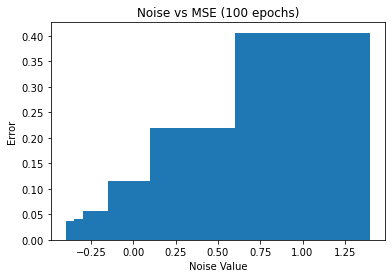

In [56]:
plt.bar(noise_levels, list(mse_list_noise2.values()))
plt.xlabel("Noise Value")
plt.ylabel("Error")
plt.title("Noise vs MSE (100 epochs)")
plt.show()

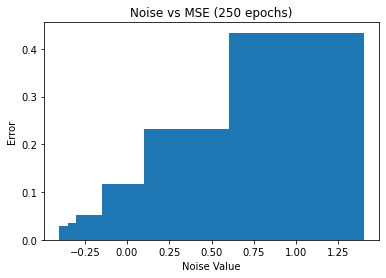

In [57]:
plt.bar(noise_levels, list(mse_list_noise3.values()))
plt.xlabel("Noise Value")
plt.ylabel("Error")
plt.title("Noise vs MSE (250 epochs)")
plt.show()

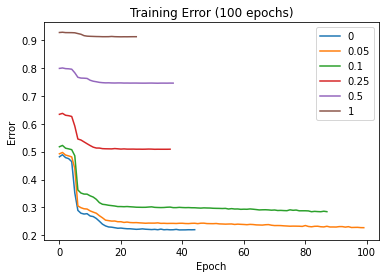

In [60]:
for i in noise_levels:
    plt.plot(error_list_noise2[i], label=i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error (100 epochs)")
plt.show()

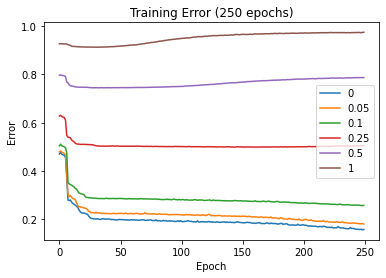

In [62]:
for i in noise_levels:
    plt.plot(error_list_noise3[i], label=i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error (250 epochs)")
plt.show()

In [65]:
num_sensors_list = [1, 3, 5, 10, 25, 50, 100]
mse_list_sensors = {}
error_list_sensors = {}

for num_sensors in num_sensors_list:
    lags = 52
    load_X = load_data('SST')
    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)


    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    # Modify the sensor locations and input generation accordingly
    ...

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

    # Get the test reconstructions
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

    # Calculate the mean squared error
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    mse_list_sensors[num_sensors] = mse
    error_list_sensors[num_sensors] = validation_errors

Training epoch 1
Error tensor(0.4769)
Training epoch 2
Error tensor(0.4867)
Training epoch 3
Error tensor(0.4751)
Training epoch 4
Error tensor(0.4748)
Training epoch 5
Error tensor(0.4741)
Training epoch 6
Error tensor(0.4725)
Training epoch 7
Error tensor(0.4737)
Training epoch 8
Error tensor(0.4701)
Training epoch 9
Error tensor(0.4581)
Training epoch 10
Error tensor(0.3442)
Training epoch 11
Error tensor(0.3239)
Training epoch 12
Error tensor(0.2884)
Training epoch 13
Error tensor(0.2765)
Training epoch 14
Error tensor(0.2633)
Training epoch 15
Error tensor(0.2531)
Training epoch 16
Error tensor(0.2371)
Training epoch 17
Error tensor(0.2306)
Training epoch 18
Error tensor(0.2270)
Training epoch 19
Error tensor(0.2234)
Training epoch 20
Error tensor(0.2210)
Training epoch 21
Error tensor(0.2210)
Training epoch 22
Error tensor(0.2221)
Training epoch 23
Error tensor(0.2220)
Training epoch 24
Error tensor(0.2208)
Training epoch 25
Error tensor(0.2196)
Training epoch 26
Error tensor(0.2

In [32]:
mse_list_sensors3 = {1: 0.027997896,
 3: 0.026828608,
 5: 0.02727606,
 10: 0.0238732,
 25: 0.02294652,
 50: 0.022302462,
 100: 0.022114463}
error_list_sensors3 = {1: np.array([0.47215444, 0.47752473, 0.4693607 , 0.4676967 , 0.46689224,
        0.46884146, 0.4632367 , 0.46588695, 0.45714268, 0.40514106,
        0.35519454, 0.3362228 , 0.31543088, 0.285976  , 0.2804983 ,
        0.26932436, 0.25278926, 0.24221215, 0.23834942, 0.23852716,
        0.23722   , 0.23840144, 0.2355667 , 0.23514684, 0.23526388,
        0.23375775, 0.23473135, 0.23420648, 0.23321654, 0.23305832,
        0.23216426, 0.23193197, 0.23183627, 0.23365606, 0.23126386,
        0.23042788, 0.23244563, 0.233544  , 0.2309756 , 0.2306832 ,
        0.23293266, 0.2318152 , 0.23254657, 0.2298435 , 0.23393247,
        0.23078832, 0.23060912, 0.2363245 , 0.23025762, 0.23025738,
        0.23174733, 0.23179664, 0.2320313 , 0.23030698, 0.2284449 ,
        0.22938715, 0.22844055, 0.23526314, 0.23357214, 0.22913136,
        0.22961943, 0.22947696, 0.22765723, 0.22911273, 0.22820857,
        0.2276424 , 0.22917365, 0.22696884, 0.22505802, 0.22577637,
        0.22573134, 0.22453131, 0.22507623, 0.2287063 , 0.22429134,
        0.22414863, 0.22464992, 0.22388814, 0.22458844, 0.22353572,
        0.22356115, 0.22343734, 0.22331423, 0.22204427, 0.22131021,
        0.22186366, 0.22262186, 0.22050504, 0.22075339, 0.21973622,
        0.22047022, 0.22273013, 0.22007638, 0.22177736, 0.21943703,
        0.21826951, 0.22028995, 0.21881805, 0.2206732 , 0.21782652,
        0.21705037, 0.21740592, 0.21577293, 0.21829219, 0.21718737,
        0.21671815, 0.2144348 , 0.21564138, 0.21344697, 0.21457456,
        0.21196212, 0.21178606, 0.21538666, 0.21387826, 0.21128282,
        0.2095588 , 0.21073781, 0.21095328, 0.20911312, 0.20876318,
        0.20972954, 0.21006933, 0.2069416 , 0.20662236, 0.20685984,
        0.20685089, 0.20466925, 0.20521052, 0.20589311, 0.20665126,
        0.20438436, 0.20149885, 0.20554745, 0.20206381, 0.20009167,
        0.20180239, 0.20164576, 0.20105524, 0.19999011, 0.20011407,
        0.19933228, 0.19709894, 0.19997324, 0.19738612, 0.1992806 ,
        0.19383919, 0.19331133, 0.19194469, 0.19348362, 0.19138092,
        0.1969216 , 0.19222943, 0.1939475 , 0.18866882, 0.18942755,
        0.18651132, 0.19234686, 0.19173133, 0.19433293, 0.18790354,
        0.18398462, 0.18423355, 0.18645288, 0.18401721, 0.18824734,
        0.18482958, 0.18415515, 0.18448439, 0.18319748, 0.18221584,
        0.18003869, 0.17959142, 0.1807318 , 0.17793533, 0.17777714,
        0.17616686, 0.1771249 , 0.18362619, 0.17684908, 0.17758666,
        0.17834602, 0.17861032, 0.17957309, 0.17470668, 0.17414923,
        0.17283922, 0.17671886, 0.17285638, 0.1731745 , 0.17656922,
        0.17419015, 0.17179944, 0.17696175, 0.17491315, 0.17098598,
        0.17060539, 0.16914202, 0.16998945, 0.16974609, 0.17041624,
        0.16861758, 0.16856216, 0.16666906, 0.16642825, 0.16678947,
        0.1701398 , 0.16648382, 0.16917089, 0.16526926, 0.1650953 ,
        0.1675624 , 0.16707301, 0.16543224, 0.16390052, 0.16375066,
        0.16281502, 0.16349305, 0.16826631, 0.16445464, 0.16457106,
        0.16173455, 0.16807522, 0.16515334, 0.16005278, 0.15907723,
        0.15894197, 0.16007249, 0.16093159, 0.15900263, 0.16060114,
        0.15780857, 0.16183479, 0.15808173, 0.15832238, 0.15460478,
        0.15485644, 0.15651344, 0.15408397, 0.15569958, 0.15605757,
        0.15458468, 0.15446024, 0.15598036, 0.1539988 , 0.15211111,
        0.15452853, 0.15482633, 0.16071042, 0.15596211, 0.1567096 ]),
 3: np.array([0.46352667, 0.46914452, 0.46280673, 0.46051934, 0.45762494,
        0.44846472, 0.35554406, 0.27992174, 0.27855515, 0.27679795,
        0.27144083, 0.27167487, 0.26858684, 0.26508668, 0.262802  ,
        0.25575015, 0.24514557, 0.2340912 , 0.22980466, 0.22776926,
        0.22448292, 0.22412044, 0.22300915, 0.22279446, 0.22246473,
        0.22453053, 0.2248627 , 0.2212331 , 0.22109257, 0.22080633,
        0.22240196, 0.21984212, 0.22041315, 0.2198487 , 0.21993639,
        0.22254989, 0.21963342, 0.2206276 , 0.21892302, 0.21897994,
        0.21905479, 0.21802163, 0.21951002, 0.21772484, 0.21726379,
        0.21956602, 0.21790794, 0.21845426, 0.2195836 , 0.21760285,
        0.21823028, 0.21675093, 0.21661732, 0.21602218, 0.21539544,
        0.21489224, 0.21645662, 0.21703808, 0.21269861, 0.21478857,
        0.21570654, 0.21122763, 0.21099326, 0.21192338, 0.21027046,
        0.2101702 , 0.21005191, 0.20991209, 0.2081369 , 0.21047199,
        0.20932955, 0.20888996, 0.20959772, 0.20644863, 0.20739917,
        0.20715506, 0.20719767, 0.20850728, 0.2073328 , 0.20524745,
        0.2046335 , 0.20702277, 0.20775859, 0.20483229, 0.20726782,
        0.2061482 , 0.20360067, 0.20287356, 0.20305713, 0.20279166,
        0.20345125, 0.20315523, 0.20279668, 0.2018558 , 0.20302778,
        0.20416352, 0.20578682, 0.20261082, 0.20211448, 0.20108676,
        0.2003266 , 0.2002846 , 0.2021278 , 0.20187186, 0.20120059,
        0.20265505, 0.19941686, 0.1988281 , 0.19772993, 0.19753206,
        0.19819103, 0.19745545, 0.19764109, 0.19545257, 0.19690515,
        0.19665127, 0.19667974, 0.19398183, 0.19618629, 0.19587357,
        0.19492033, 0.19660673, 0.19305001, 0.1930008 , 0.1936881 ,
        0.1963588 , 0.1928103 , 0.19124742, 0.19244808, 0.19176741,
        0.19022739, 0.19278163, 0.1922927 , 0.1896705 , 0.18873437,
        0.19288579, 0.1936363 , 0.19043231, 0.1879849 , 0.1877324 ,
        0.18781267, 0.18677431, 0.1862456 , 0.18464106, 0.18836023,
        0.18621644, 0.18592359, 0.18639302, 0.1817866 , 0.18577908,
        0.1865694 , 0.18070659, 0.17968291, 0.17936344, 0.18418361,
        0.1870949 , 0.17871611, 0.17641161, 0.18006968, 0.18271469,
        0.17717837, 0.17674758, 0.17712176, 0.17453484, 0.17702748,
        0.17643267, 0.17425111, 0.17471726, 0.17191896, 0.1701625 ,
        0.17319357, 0.17044774, 0.17595017, 0.17069142, 0.17239997,
        0.17303833, 0.17044169, 0.16858354, 0.16809486, 0.16933897,
        0.16677693, 0.16724433, 0.18131827, 0.16777152, 0.16627918,
        0.16512331, 0.1650493 , 0.16474713, 0.17188066, 0.16908184,
        0.16512822, 0.16553296, 0.16400422, 0.16205166, 0.16381119,
        0.16923532, 0.16209093, 0.1627643 , 0.16255248, 0.16107799,
        0.16613917, 0.16428411, 0.1616464 , 0.1609186 , 0.16260062,
        0.16057484, 0.15832177, 0.1585438 , 0.15839507, 0.15771574,
        0.15789661, 0.15758175, 0.16580047, 0.16653366, 0.16444233,
        0.15998277, 0.15741025, 0.15486565, 0.15520735, 0.15505427,
        0.15445237, 0.15352042, 0.15441045, 0.15782128, 0.15412419,
        0.15357108, 0.15337233, 0.15285172, 0.15223321, 0.15110599,
        0.15162532, 0.15071228, 0.14977367, 0.15037645, 0.14915636,
        0.14998066, 0.1507011 , 0.14812946, 0.15138449, 0.1480276 ,
        0.14951195, 0.14791703, 0.1480419 , 0.14888145, 0.14729838,
        0.14618845, 0.14453611, 0.14581442, 0.14513396, 0.14750536]),
 5: np.array([0.47091547, 0.47396967, 0.4680555 , 0.46195242, 0.41616935,
        0.26881704, 0.26438496, 0.2607472 , 0.25708917, 0.2533088 ,
        0.25097466, 0.24779254, 0.24865006, 0.24952157, 0.24629849,
        0.24667576, 0.24419698, 0.24148981, 0.23543973, 0.22599456,
        0.22302778, 0.22194764, 0.22187112, 0.22043222, 0.21913674,
        0.2181449 , 0.21767837, 0.21646896, 0.21639207, 0.21624126,
        0.21602865, 0.21562968, 0.21668798, 0.2156326 , 0.2168446 ,
        0.21464941, 0.21474878, 0.21469241, 0.21410757, 0.21464491,
        0.21528366, 0.21409881, 0.21433085, 0.21420798, 0.21434258,
        0.21437477, 0.21435748, 0.21528557, 0.21326534, 0.21599719,
        0.21346097, 0.21366893, 0.21637332, 0.21472159, 0.21369377,
        0.21389401, 0.21388257, 0.21371737, 0.21389769, 0.21310748,
        0.21285613, 0.21375275, 0.21287015, 0.21264783, 0.21344844,
        0.21361892, 0.2124158 , 0.21230796, 0.21236806, 0.21172722,
        0.21188493, 0.2123547 , 0.21141727, 0.21227458, 0.21175715,
        0.21131621, 0.21038026, 0.2103165 , 0.21017116, 0.21006025,
        0.21042626, 0.20987488, 0.21069925, 0.21024005, 0.20886938,
        0.2097123 , 0.20968124, 0.21023628, 0.21124367, 0.2090141 ,
        0.20768811, 0.20679276, 0.20674726, 0.2066236 , 0.20823003,
        0.20496961, 0.20596257, 0.20558259, 0.20531552, 0.20547862,
        0.20528819, 0.20506288, 0.20747425, 0.20369895, 0.2057455 ,
        0.20479292, 0.2029625 , 0.20372792, 0.20181662, 0.20501271,
        0.20326592, 0.20184353, 0.20136917, 0.20355585, 0.20072947,
        0.201525  , 0.20194365, 0.20052727, 0.2057696 , 0.19994496,
        0.2024734 , 0.20160289, 0.19803584, 0.1971333 , 0.201744  ,
        0.19870731, 0.19993885, 0.19779353, 0.19770427, 0.19578952,
        0.19680801, 0.19494362, 0.19515613, 0.19513075, 0.19433717,
        0.1942082 , 0.19446295, 0.19447197, 0.19461352, 0.1937867 ,
        0.19433029, 0.19191311, 0.19068004, 0.19140103, 0.18968333,
        0.18989967, 0.19093871, 0.1906988 , 0.1910719 , 0.19248891,
        0.19558452, 0.19060175, 0.18821919, 0.18760216, 0.18596247,
        0.18678859, 0.18718553, 0.18861748, 0.18805872, 0.18785743,
        0.18481661, 0.19155057, 0.18623045, 0.18087612, 0.18045244,
        0.17951836, 0.18478961, 0.18798913, 0.17979   , 0.17758621,
        0.17801957, 0.1782521 , 0.17573531, 0.18146586, 0.17684951,
        0.17703956, 0.17345215, 0.17456073, 0.1725492 , 0.17234749,
        0.17160945, 0.17263268, 0.17223631, 0.17451294, 0.17898032,
        0.17234218, 0.16919203, 0.17517777, 0.17424503, 0.16686285,
        0.16528055, 0.16540022, 0.16515486, 0.16488327, 0.16718493,
        0.1633383 , 0.1648228 , 0.1641892 , 0.16226077, 0.16107425,
        0.15971828, 0.16137667, 0.1664419 , 0.16353393, 0.15957162,
        0.16183342, 0.1593698 , 0.16058795, 0.16308774, 0.16027342,
        0.1582351 , 0.1563391 , 0.15749395, 0.15521887, 0.15534794,
        0.15397532, 0.1559904 , 0.15399195, 0.15371594, 0.1533043 ,
        0.15289094, 0.15360557, 0.15712772, 0.1538699 , 0.15240927,
        0.15348008, 0.15127137, 0.1510139 , 0.15019369, 0.14918232,
        0.14879777, 0.15000209, 0.14896747, 0.14962931, 0.14795376,
        0.1475337 , 0.14769676, 0.14688922, 0.14858127, 0.1491454 ,
        0.14608721, 0.1467725 , 0.14617229, 0.14506774, 0.1442787 ,
        0.1435572 , 0.1453314 , 0.14823136, 0.1448329 , 0.14769723]),
 10: np.array([0.4750319 , 0.47645095, 0.46845147, 0.44728673, 0.30361274,
        0.27014494, 0.2652909 , 0.25888038, 0.2519152 , 0.24858189,
        0.24509102, 0.23883718, 0.23106502, 0.22714058, 0.22504286,
        0.22556101, 0.22551058, 0.22484751, 0.22393441, 0.22340535,
        0.22364497, 0.22257508, 0.22264795, 0.22112994, 0.22130975,
        0.22069603, 0.22037847, 0.22153327, 0.22046964, 0.21975894,
        0.2205104 , 0.22208638, 0.21996626, 0.21919014, 0.22072873,
        0.21981415, 0.22027871, 0.22080432, 0.21892779, 0.21886598,
        0.21962868, 0.2184307 , 0.2203844 , 0.21906935, 0.21907887,
        0.21864021, 0.22188322, 0.22061601, 0.21851027, 0.21894406,
        0.21856222, 0.21890801, 0.2186512 , 0.21773362, 0.2165094 ,
        0.21676926, 0.21612568, 0.21644749, 0.21690464, 0.21627428,
        0.21634392, 0.21528439, 0.2151417 , 0.21433072, 0.2145904 ,
        0.21813066, 0.21386573, 0.21268049, 0.210626  , 0.21150666,
        0.21038887, 0.2103914 , 0.21310616, 0.20893897, 0.20758542,
        0.2072778 , 0.2089546 , 0.20767939, 0.20818861, 0.20574398,
        0.2038459 , 0.20248283, 0.20422304, 0.20515928, 0.20278218,
        0.2023153 , 0.20048073, 0.199782  , 0.19874468, 0.19782808,
        0.19585413, 0.19599959, 0.19980177, 0.19791213, 0.19380577,
        0.18881166, 0.18831399, 0.18861419, 0.18992689, 0.18437804,
        0.1862366 , 0.19233182, 0.18373157, 0.18151677, 0.18078749,
        0.17868567, 0.18297245, 0.18413642, 0.17926812, 0.17822874,
        0.17705251, 0.17674696, 0.17656435, 0.17548701, 0.17686014,
        0.17447942, 0.17511739, 0.17405598, 0.17328455, 0.17521629,
        0.17334378, 0.17251764, 0.17244641, 0.1721554 , 0.17394067,
        0.17169298, 0.17185923, 0.17219265, 0.1705771 , 0.16888292,
        0.1713326 , 0.16925047, 0.16822952, 0.16749373, 0.1703732 ,
        0.16989899, 0.16583419, 0.16773514, 0.16639027, 0.16530722,
        0.16523266, 0.16698198, 0.16599368, 0.16368894, 0.16679713,
        0.16462816, 0.16421132, 0.16425414, 0.1632502 , 0.16396585,
        0.16463521, 0.16295387, 0.16302359, 0.16091022, 0.16452141,
        0.1645281 , 0.16289565, 0.16192032, 0.15956935, 0.16045682,
        0.15878506, 0.1583159 , 0.1576212 , 0.15765193, 0.15701795,
        0.15636604, 0.15528882, 0.15551037, 0.1560061 , 0.15546472,
        0.15883464, 0.15662052, 0.1555482 , 0.15392415, 0.1536658 ,
        0.15282008, 0.15472157, 0.15179782, 0.15074891, 0.15047473,
        0.15072045, 0.15218297, 0.15148969, 0.14949022, 0.1482273 ,
        0.14827591, 0.14804083, 0.14892095, 0.14666189, 0.14797398,
        0.14670433, 0.14656144, 0.1458525 , 0.14422736, 0.14591236,
        0.1469106 , 0.14579605, 0.14401045, 0.14549667, 0.14494981,
        0.14398885, 0.14238591, 0.14591087, 0.14375664, 0.14308563,
        0.14209978, 0.14237638, 0.14131129, 0.14255597, 0.14152269,
        0.13966903, 0.140803  , 0.13996826, 0.13896331, 0.14063917,
        0.13833475, 0.13933773, 0.14163122, 0.13980223, 0.14083841,
        0.13671221, 0.13681762, 0.13565996, 0.13610873, 0.1355503 ,
        0.13505815, 0.13502373, 0.13424678, 0.13592514, 0.13762283,
        0.13672778, 0.13373363, 0.13546024, 0.13778424, 0.13462631,
        0.13272725, 0.13373758, 0.13540089, 0.13335912, 0.13316391,
        0.13259487, 0.1315418 , 0.13391498, 0.13201489, 0.13135724,
        0.13484474, 0.13169739, 0.13003413, 0.1323665 , 0.13195242]),
 25: np.array([0.48161677, 0.47431654, 0.4652855 , 0.38293025, 0.26996332,
        0.26119402, 0.25701934, 0.25209177, 0.24744937, 0.24662827,
        0.24583338, 0.24333592, 0.24115765, 0.23759381, 0.2283004 ,
        0.22404791, 0.22329769, 0.22198497, 0.22079773, 0.21914713,
        0.21994601, 0.21839263, 0.21908058, 0.21822716, 0.21715932,
        0.2164454 , 0.21616057, 0.2159753 , 0.21648861, 0.21688506,
        0.21622649, 0.21570796, 0.21591882, 0.21634673, 0.21471423,
        0.2160548 , 0.21395952, 0.21410412, 0.21427232, 0.21464464,
        0.21318805, 0.21344452, 0.21274887, 0.21251653, 0.21386935,
        0.21499242, 0.21033387, 0.21083073, 0.20868771, 0.20856829,
        0.20724742, 0.20443499, 0.19965255, 0.19561826, 0.19387917,
        0.18669221, 0.1888204 , 0.18398441, 0.18477343, 0.18275678,
        0.18215694, 0.1806012 , 0.17910066, 0.17752461, 0.17879239,
        0.17941552, 0.17776732, 0.17789352, 0.17627272, 0.1749352 ,
        0.17592596, 0.17297308, 0.17401674, 0.1723793 , 0.17245725,
        0.17187437, 0.1714336 , 0.1703275 , 0.17181072, 0.16910483,
        0.16999348, 0.16826509, 0.16903901, 0.16987874, 0.16770265,
        0.16983376, 0.16811977, 0.16707754, 0.16552545, 0.1658221 ,
        0.16423477, 0.1670183 , 0.16444185, 0.16430259, 0.1639063 ,
        0.16363959, 0.16171701, 0.1617843 , 0.16067563, 0.16334774,
        0.16113   , 0.16172351, 0.16146216, 0.15892002, 0.15962295,
        0.15934576, 0.15819238, 0.15875314, 0.15803257, 0.1581167 ,
        0.15752397, 0.15777506, 0.15773326, 0.1569909 , 0.15577093,
        0.15570523, 0.15552717, 0.1557693 , 0.15451643, 0.15359275,
        0.15279463, 0.15256268, 0.15283471, 0.15242879, 0.1532973 ,
        0.15229689, 0.15106185, 0.15033336, 0.15096453, 0.15057397,
        0.14971156, 0.15152979, 0.15204465, 0.14868146, 0.14857952,
        0.14845192, 0.1490227 , 0.14841308, 0.14693499, 0.14808041,
        0.14742844, 0.14645934, 0.14765854, 0.14651968, 0.14585456,
        0.14512166, 0.1457317 , 0.14499211, 0.1445886 , 0.14430936,
        0.14511536, 0.14378235, 0.1429185 , 0.14188477, 0.14273193,
        0.14341414, 0.14105614, 0.14117989, 0.14159633, 0.1404586 ,
        0.14108403, 0.14148176, 0.14028847, 0.13899569, 0.1390668 ,
        0.13901134, 0.13918902, 0.14088033, 0.14005853, 0.14021239,
        0.13758004, 0.13876492, 0.13759343, 0.1365591 , 0.13576798,
        0.13666543, 0.1375408 , 0.13682295, 0.1344672 , 0.13485928,
        0.13626385, 0.13748406, 0.13460791, 0.13387416, 0.13451348,
        0.1351353 , 0.13419811, 0.13448733, 0.13317043, 0.13261366,
        0.1315553 , 0.1321534 , 0.13241558, 0.13330512, 0.13253699,
        0.13186254, 0.13208203, 0.13058285, 0.13059668, 0.13146904,
        0.13064823, 0.13080612, 0.12879995, 0.12846969, 0.1307402 ,
        0.12885754, 0.12882763, 0.1283744 , 0.12935276, 0.12923387,
        0.12825984, 0.12830928, 0.12852344, 0.12774593, 0.12867135,
        0.12763518, 0.1286101 , 0.12825114, 0.12735282, 0.12566388,
        0.12627676, 0.12652169, 0.12660804, 0.12627952, 0.12595437,
        0.126632  , 0.12581687, 0.12424265, 0.12604101, 0.12432558,
        0.1248608 , 0.1251584 , 0.1249192 , 0.12313908, 0.12300856,
        0.12305865, 0.12419172, 0.12442344, 0.12387054, 0.12297723,
        0.12611069, 0.12399343, 0.12297835, 0.12369584, 0.12414404,
        0.12368394, 0.12399211, 0.12281366, 0.12310217, 0.12331568]),
 50: np.array([0.48904148, 0.46891624, 0.42394042, 0.27688918, 0.26136166,
        0.25556377, 0.24983905, 0.24427694, 0.2416245 , 0.23878407,
        0.2349523 , 0.22869521, 0.22217135, 0.21918981, 0.21875997,
        0.21751246, 0.21641488, 0.2156946 , 0.21497682, 0.21454675,
        0.21379289, 0.2130589 , 0.21397217, 0.21253648, 0.2133319 ,
        0.21214059, 0.21221447, 0.21286069, 0.21098089, 0.21166907,
        0.21159066, 0.20924875, 0.20689696, 0.20603374, 0.20275046,
        0.20128354, 0.19961262, 0.20122524, 0.19812997, 0.19782571,
        0.19679458, 0.19507974, 0.19367136, 0.19201803, 0.20447555,
        0.19872403, 0.19413295, 0.19236426, 0.18944898, 0.18700579,
        0.1880711 , 0.18387242, 0.18155785, 0.18125518, 0.18008693,
        0.17962256, 0.17621359, 0.17662905, 0.17453003, 0.1758143 ,
        0.1735995 , 0.17503636, 0.17272483, 0.17361423, 0.17319044,
        0.1736076 , 0.17179942, 0.17015363, 0.17010468, 0.1692821 ,
        0.17072326, 0.16924664, 0.16989626, 0.1675358 , 0.16630256,
        0.16635582, 0.16705322, 0.1665829 , 0.16539359, 0.16542397,
        0.16408636, 0.1637972 , 0.16369149, 0.16465123, 0.16497566,
        0.16351478, 0.1620592 , 0.1611307 , 0.16052891, 0.16273479,
        0.16155185, 0.16083002, 0.15909791, 0.15840645, 0.15893082,
        0.15881588, 0.1574891 , 0.15801685, 0.15776236, 0.1572947 ,
        0.1578196 , 0.15665992, 0.15606599, 0.15487882, 0.15399447,
        0.15429215, 0.15585575, 0.15447396, 0.15403293, 0.15361135,
        0.15402508, 0.15359579, 0.15208468, 0.15282689, 0.1513784 ,
        0.1515547 , 0.15029557, 0.15020843, 0.15142182, 0.14945628,
        0.14839265, 0.14994007, 0.1498906 , 0.1495227 , 0.1492667 ,
        0.14787097, 0.146922  , 0.14884265, 0.14728571, 0.14595489,
        0.1457452 , 0.1449026 , 0.14576598, 0.14519653, 0.14509057,
        0.14446793, 0.14371575, 0.14353774, 0.14329794, 0.14295624,
        0.14203972, 0.14237857, 0.14464197, 0.14199439, 0.14279723,
        0.14171088, 0.14152157, 0.14044605, 0.13995436, 0.13986643,
        0.13991506, 0.14047706, 0.13968392, 0.13962658, 0.13948423,
        0.14070834, 0.14190553, 0.13792476, 0.13679996, 0.13726403,
        0.13711306, 0.13652147, 0.13761216, 0.13672137, 0.13653964,
        0.13530254, 0.13512374, 0.13423918, 0.13457619, 0.13522582,
        0.1349005 , 0.13506392, 0.1357141 , 0.13414666, 0.13322327,
        0.13320301, 0.13302566, 0.13218893, 0.13196439, 0.13328385,
        0.13534462, 0.13146761, 0.13147941, 0.13191178, 0.13021293,
        0.13090047, 0.1317496 , 0.1308504 , 0.12909879, 0.13003357,
        0.13162144, 0.12951519, 0.13010278, 0.13114212, 0.1296032 ,
        0.12872666, 0.12814175, 0.12906092, 0.1283397 , 0.12754914,
        0.12698519, 0.12829833, 0.1272008 , 0.12609176, 0.13122289,
        0.12817216, 0.12760308, 0.12782754, 0.12662645, 0.12620993,
        0.12728196, 0.13089469, 0.12653302, 0.12575224, 0.12608619,
        0.12454768, 0.12426398, 0.1248301 , 0.12597169, 0.12490498,
        0.12480182, 0.12442985, 0.12593307, 0.12477162, 0.12500732,
        0.12437023, 0.12490518, 0.12605591, 0.12459424, 0.1235253 ,
        0.12352365, 0.12348412, 0.1244152 , 0.1235406 , 0.12375195,
        0.12365893, 0.12264001, 0.12284932, 0.12386643, 0.12416885,
        0.12473028, 0.12471022, 0.1231612 , 0.12399471, 0.12575023,
        0.12267429, 0.12193658, 0.12147756, 0.12168507, 0.12252875]),
 100: np.array([0.49172777, 0.45807248, 0.32540444, 0.2634707 , 0.25498018,
        0.25192666, 0.2467187 , 0.24196528, 0.2366166 , 0.23462056,
        0.22894318, 0.22109728, 0.2157875 , 0.21366414, 0.21480633,
        0.21279058, 0.21135932, 0.21007033, 0.20962875, 0.208856  ,
        0.2090395 , 0.20839983, 0.20664603, 0.20614463, 0.2028076 ,
        0.19910198, 0.19841738, 0.19599798, 0.19599533, 0.19408025,
        0.19661425, 0.18963096, 0.19057271, 0.19044217, 0.18796097,
        0.1837448 , 0.18124218, 0.18700409, 0.18147837, 0.18165208,
        0.17951779, 0.1794543 , 0.17931426, 0.17822148, 0.17951258,
        0.17702028, 0.17602108, 0.18060684, 0.17820908, 0.17761011,
        0.17726114, 0.17465165, 0.17398658, 0.1739625 , 0.17371967,
        0.17483003, 0.17521803, 0.17374596, 0.17308082, 0.17285833,
        0.17227222, 0.17113274, 0.1705306 , 0.17162114, 0.1711884 ,
        0.16999649, 0.1691688 , 0.16911583, 0.16848777, 0.16841914,
        0.16761298, 0.16900201, 0.16853444, 0.16936159, 0.16723984,
        0.16566409, 0.1664527 , 0.16567916, 0.1636782 , 0.16388635,
        0.16375853, 0.16425659, 0.16152604, 0.16256642, 0.16135673,
        0.16206804, 0.16000201, 0.16026028, 0.16009073, 0.16004093,
        0.15861523, 0.15900037, 0.15899542, 0.15792207, 0.1566042 ,
        0.15572153, 0.15593891, 0.15618831, 0.15569884, 0.15497448,
        0.1548394 , 0.15336718, 0.15437041, 0.15255924, 0.15447946,
        0.15133731, 0.15307167, 0.15166266, 0.1724492 , 0.16127115,
        0.15640078, 0.15301816, 0.1511796 , 0.15138294, 0.15269686,
        0.15119302, 0.149844  , 0.15835573, 0.15474112, 0.14973263,
        0.14929427, 0.14936468, 0.14829288, 0.14791705, 0.14667766,
        0.14589024, 0.1461386 , 0.14704673, 0.14544754, 0.14521344,
        0.14409964, 0.1454212 , 0.14368325, 0.14429586, 0.14539285,
        0.14530945, 0.14217862, 0.14456294, 0.14255936, 0.14212087,
        0.14322066, 0.14158702, 0.14049323, 0.14194213, 0.14194354,
        0.14161105, 0.1398572 , 0.13941169, 0.13967428, 0.14059156,
        0.13981594, 0.13948634, 0.13971908, 0.13852014, 0.13942188,
        0.13869585, 0.1373113 , 0.137298  , 0.13745971, 0.13724796,
        0.13925058, 0.13924111, 0.13563015, 0.1369411 , 0.13750169,
        0.13728385, 0.13559844, 0.13582456, 0.13361923, 0.13566387,
        0.1352306 , 0.13542235, 0.1351073 , 0.13334861, 0.13366032,
        0.13377143, 0.13268046, 0.13350344, 0.13496147, 0.13300139,
        0.13334443, 0.13222113, 0.13386567, 0.13336384, 0.13412432,
        0.13283564, 0.13231876, 0.13164754, 0.13140896, 0.13059053,
        0.13059054, 0.13038985, 0.13096754, 0.13006292, 0.13058603,
        0.13025482, 0.13216169, 0.13228583, 0.13034606, 0.12911673,
        0.1280623 , 0.12949112, 0.12809484, 0.1281716 , 0.12819661,
        0.12856779, 0.13071252, 0.12953997, 0.12873006, 0.12909898,
        0.12879965, 0.12852283, 0.12901983, 0.13071913, 0.1278472 ,
        0.12733051, 0.12874937, 0.1273179 , 0.12787655, 0.1267846 ,
        0.12637128, 0.12675402, 0.12774068, 0.12656783, 0.12584336,
        0.12618275, 0.1260758 , 0.12542811, 0.12689066, 0.1267035 ,
        0.12650621, 0.12656844, 0.12446302, 0.12735894, 0.12544858,
        0.12572938, 0.12394211, 0.1242837 , 0.12461703, 0.12557237,
        0.12400675, 0.12390465, 0.12552316, 0.12391101, 0.12452178,
        0.1249264 , 0.12536879, 0.12408621, 0.1233513 , 0.12285172])}

In [71]:
mse_list_sensors2 = {1: 0.037608292,
 3: 0.0363204,
 5: 0.034671895,
 10: 0.036929544,
 25: 0.03184576,
 50: 0.029400062,
 100: 0.02762184}
error_list_sensors2 = {1: torch.tensor([0.4769, 0.4867, 0.4751, 0.4748, 0.4741, 0.4725, 0.4737, 0.4701, 0.4581,
         0.3442, 0.3239, 0.2884, 0.2765, 0.2633, 0.2531, 0.2371, 0.2306, 0.2270,
         0.2234, 0.2210, 0.2210, 0.2221, 0.2220, 0.2208, 0.2196, 0.2207, 0.2192,
         0.2179, 0.2206, 0.2197, 0.2185, 0.2178, 0.2208, 0.2186, 0.2186, 0.2201,
         0.2175, 0.2174, 0.2169, 0.2175, 0.2159, 0.2161, 0.2170, 0.2154, 0.2158,
         0.2150, 0.2181, 0.2148, 0.2138, 0.2154, 0.2135, 0.2150, 0.2170, 0.2139,
         0.2132, 0.2128, 0.2131, 0.2119, 0.2123, 0.2119, 0.2125, 0.2146, 0.2131]),
 3: torch.tensor([0.4817, 0.4842, 0.4778, 0.4752, 0.4724, 0.4670, 0.3904, 0.2939, 0.2871,
         0.2771, 0.2724, 0.2695, 0.2699, 0.2697, 0.2655, 0.2531, 0.2510, 0.2323,
         0.2276, 0.2241, 0.2234, 0.2236, 0.2217, 0.2235, 0.2198, 0.2209, 0.2204,
         0.2202, 0.2178, 0.2194, 0.2181, 0.2182, 0.2185, 0.2177, 0.2180, 0.2178,
         0.2180, 0.2175, 0.2161, 0.2178, 0.2177, 0.2183, 0.2167, 0.2164]),
 5: torch.tensor([0.4723, 0.4781, 0.4706, 0.4655, 0.4458, 0.3075, 0.2710, 0.2660, 0.2655,
         0.2597, 0.2577, 0.2547, 0.2540, 0.2532, 0.2520, 0.2494, 0.2473, 0.2437,
         0.2351, 0.2331, 0.2309, 0.2288, 0.2285, 0.2269, 0.2259, 0.2248, 0.2248,
         0.2244, 0.2236, 0.2225, 0.2227, 0.2218, 0.2217, 0.2220, 0.2219, 0.2244,
         0.2225, 0.2214, 0.2218, 0.2217, 0.2204, 0.2213, 0.2212, 0.2200, 0.2197,
         0.2189, 0.2179, 0.2184, 0.2178, 0.2175, 0.2166, 0.2180, 0.2169, 0.2171,
         0.2165, 0.2170, 0.2174, 0.2155, 0.2149, 0.2143, 0.2141, 0.2185, 0.2140,
         0.2131, 0.2152, 0.2129, 0.2127, 0.2130, 0.2130, 0.2129, 0.2140, 0.2129]),
 10: torch.tensor([0.4755, 0.4751, 0.4703, 0.4627, 0.4205, 0.2785, 0.2664, 0.2620, 0.2601,
         0.2587, 0.2546, 0.2503, 0.2454, 0.2386, 0.2275, 0.2234, 0.2212, 0.2214,
         0.2196, 0.2205, 0.2180, 0.2187, 0.2180, 0.2167, 0.2174, 0.2177, 0.2165,
         0.2154, 0.2166, 0.2158, 0.2161, 0.2161, 0.2164]),
 25: torch.tensor([0.4752, 0.4649, 0.4267, 0.2947, 0.2652, 0.2588, 0.2557, 0.2507, 0.2457,
         0.2414, 0.2381, 0.2312, 0.2248, 0.2229, 0.2202, 0.2190, 0.2179, 0.2185,
         0.2179, 0.2166, 0.2155, 0.2186, 0.2141, 0.2144, 0.2134, 0.2133, 0.2100,
         0.2047, 0.1986, 0.1987, 0.1965, 0.1961, 0.1957, 0.1942, 0.1923, 0.1906,
         0.1889, 0.1896, 0.1879, 0.1864, 0.1858, 0.1865, 0.1873, 0.1850, 0.1852,
         0.1858, 0.1850, 0.1846, 0.1846, 0.1830, 0.1812, 0.1813, 0.1814, 0.1806,
         0.1797, 0.1796, 0.1784, 0.1795, 0.1785, 0.1783, 0.1782, 0.1774, 0.1777,
         0.1767, 0.1770, 0.1755, 0.1753, 0.1756, 0.1760, 0.1751, 0.1752, 0.1745,
         0.1737, 0.1749, 0.1738, 0.1753, 0.1747, 0.1747]),
 50: torch.tensor([0.47542706, 0.45574355, 0.35087618, 0.2688625 , 0.26179114,
        0.25776312, 0.25136238, 0.24755658, 0.24582487, 0.24189089,
        0.23656817, 0.22692871, 0.22390711, 0.22452523, 0.22188607,
        0.22009435, 0.22083418, 0.21944715, 0.21886644, 0.2190683 ,
        0.21839479, 0.21740176, 0.21681021, 0.21750204, 0.21622333,
        0.21776956, 0.2164064 , 0.21600054, 0.21507487, 0.21639995,
        0.21712069, 0.21532045, 0.21558025, 0.21380581, 0.21201524,
        0.20812798, 0.20664562, 0.20392776, 0.20358063, 0.20153902,
        0.2014046 , 0.20164059, 0.1999184 , 0.20045635, 0.1988438 ,
        0.19658552, 0.19452775, 0.19181176, 0.18646714, 0.1853635 ,
        0.1825193 , 0.1916478 , 0.18250185, 0.18207867, 0.18055446,
        0.17869264, 0.17771159, 0.17675278, 0.1763171 , 0.17705867,
        0.17459689, 0.17436835, 0.17370029, 0.17341544, 0.17459781,
        0.1737473 , 0.17388874, 0.17234948, 0.17303933, 0.17196506,
        0.17083994, 0.17104064, 0.16939507, 0.1711272 , 0.17069562,
        0.1685624 , 0.17101805, 0.16742884, 0.16876891, 0.16610229,
        0.1662345 , 0.16588198, 0.1659226 , 0.1642129 , 0.16325243,
        0.16375706, 0.16316828, 0.1620772 , 0.16431011, 0.16257456,
        0.16109319, 0.16079892, 0.16128437, 0.16238475, 0.16003692,
        0.15973082, 0.15878905, 0.15834995, 0.15961257, 0.15763436]),
 100: torch.tensor([0.5010994 , 0.43363324, 0.27903175, 0.26015016, 0.25561014,
        0.25093776, 0.2468777 , 0.24152309, 0.2355434 , 0.22681533,
        0.22297502, 0.22007741, 0.21837823, 0.2180055 , 0.21669252,
        0.21635142, 0.2152602 , 0.21420789, 0.21485947, 0.21344723,
        0.21353646, 0.21148624, 0.21015306, 0.20777507, 0.20610105,
        0.20600055, 0.2040583 , 0.2039495 , 0.20252317, 0.20140822,
        0.20157637, 0.20036472, 0.19873819, 0.1993841 , 0.19877748,
        0.197958  , 0.19554456, 0.19172709, 0.18997385, 0.18418323,
        0.18064025, 0.18381774, 0.17740437, 0.17950521, 0.1786939 ,
        0.1767616 , 0.17542593, 0.17469737, 0.17274988, 0.1752673 ,
        0.1734478 , 0.17095387, 0.17179814, 0.17129633, 0.1700546 ,
        0.17125876, 0.16963845, 0.1685672 , 0.16847062, 0.16708028,
        0.16696395, 0.16964461, 0.1684275 , 0.16804218, 0.16576368,
        0.16514833, 0.16382422, 0.16554646, 0.16304445, 0.1632256 ,
        0.1626161 , 0.16213709, 0.16195913, 0.1607773 , 0.1605696 ,
        0.15930434, 0.1592448 , 0.1587561 , 0.1589506 , 0.15940133,
        0.16134587, 0.15743995, 0.1582119 , 0.15844798, 0.15642364,
        0.15575886, 0.15567552, 0.15559502, 0.1586205 , 0.15691414,
        0.15411592, 0.15370643, 0.15645072, 0.15470196, 0.1521632 ,
        0.15386385, 0.1522741 , 0.15193392, 0.15051086, 0.15143307])}

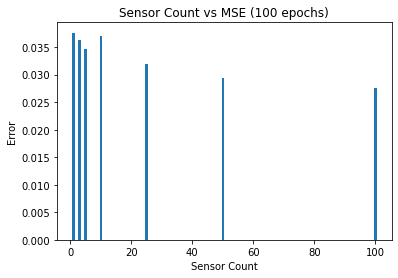

In [75]:
plt.bar(num_sensors_list, list(mse_list_sensors2.values()))
plt.xlabel("Sensor Count")
plt.ylabel("Error")
plt.title("Sensor Count vs MSE (100 epochs)")
plt.show()

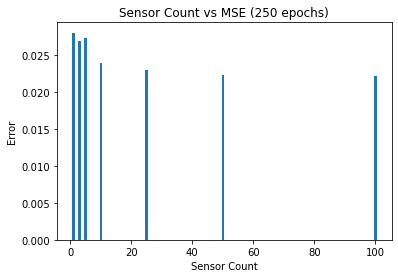

In [76]:
plt.bar(num_sensors_list, list(mse_list_sensors3.values()))
plt.xlabel("Sensor Count")
plt.ylabel("Error")
plt.title("Sensor Count vs MSE (250 epochs)")
plt.show()

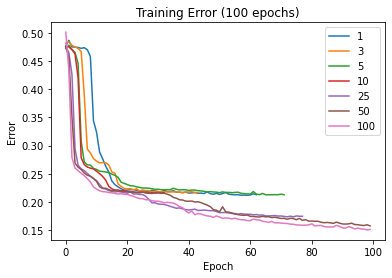

In [78]:
for i in num_sensors_list:
    plt.plot(error_list_sensors2[i], label=i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error (100 epochs)")
plt.show()

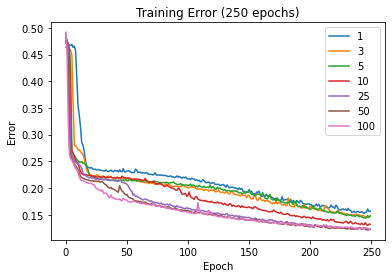

In [79]:
for i in num:
    plt.plot(error_list_sensors3[i], label=i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error (250 epochs)")
plt.show()